In [1]:
import tensorflow as tf
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from skimage import util
from math import exp, log
from tensorflow.python.keras.engine.base_layer import Layer
from matplotlib import rc
rc('mathtext', default='regular')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [23]:
class CIFARLoader():
    def __init__(self):
        (self.train_data, self.train_label), (self.test_data, self.test_label) = tf.keras.datasets.cifar10.load_data()
       
        self.train_data = self.train_data.astype(np.float32)/ 255.0     # [50000, 32, 32, 3]
        self.test_data = self.test_data.astype(np.float32) / 255.0      # [10000, 32, 32, 3]
        self.train_label = self.train_label.astype(np.int32)    # [50000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        # 从数据集中随机取出batch_size个元素并返回
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]
    
#     def get_local_noise(self, noise_num, batch_size=2000):
#         """
#         Generate noise_num # of gassaion noise knowing location 
        
#         """

#         process_image = np.copy(self.test_data[:batch_size])
        
#         W_x = intitial_W_x(process_image)
#         uncer = np.zeros(W_x[:,0,0,:,0].shape) + 0.1
#         base = uncer + 0.4
        
#         index_noise = np.random.randint(0, 32*32, noise_num)
#         for i in index_noise:
#             process_image[:,int(i/32),int(i%32),:] = process_image[:,int(i/32),int(i%32),:] + np.random.randn(3) * 0.2
            
#             W_x[:,int(i/32),int(i%32),:] = np.moveaxis(np.array([W_x[:,int(i/32),int(i%32),:,0], 
#                                                 1-W_x[:,int(i/32),int(i%32),:,0] - uncer, uncer, base]), 0, -1)
            
#         return tf.clip_by_value(process_image, 0, 1), self.test_label[:batch_size], W_x 
    def get_local_noise(self, noise_num=400, batch_size=5000):
        """
        Generate noise_num # of gassaion noise knowing location 
        
        """

        process_image = np.copy(self.test_data[:batch_size])
        W_x = intitial_W_x(process_image)
        uncer_mass = np.zeros(W_x[:,0,0,:,0].shape) + 0.01
        base_rate = np.zeros(W_x[:,0,0,:,0].shape) + 0.5
        image_size = process_image.shape[1]
        index_noise = np.random.randint(0, image_size*image_size, noise_num)
        
        for i in index_noise:
            noise_value = np.random.randn(batch_size,3) * 0.4
            feature_value = process_image[:,int(i/image_size),int(i%image_size),:]
            process_image[:,int(i/image_size),int(i%image_size),:] = feature_value + noise_value
            belief_mass = W_x[:,int(i/image_size),int(i%image_size),:,0] 
            disbelief_mass = 1 - belief_mass - uncer_mass
            W_x[:,int(i/image_size),int(i%image_size),:] = np.moveaxis(np.array([belief_mass,disbelief_mass,uncer_mass,base_rate]), 0, -1)
            
        return tf.clip_by_value(process_image, 0, 1), self.test_label[:batch_size], W_x, index_noise
    
    def get_noise(self, noise_mode):
        process_image = np.copy(self.test_data[:2000])
        noise_gs_img = util.random_noise(process_image,mode=noise_mode)
        return noise_gs_img, self.test_label[:2000]

    def get_test(self, size):

        return self.test_data[:size], self.test_label[:size]
    
data_loader = CIFARLoader()

In [4]:
def intitial_W_x(X):
    """
    X - 50,32,32,3
    return W_x - 50,32,32,3,4
    
    """
    W_dis = np.zeros(X.shape).astype(np.float32)
    W_base = W_dis + 0.5
    W_x = np.array([X, W_dis, 1 - X, W_base]).astype(np.float32)
    W_x = np.moveaxis(W_x, 0, -1)
    
    return W_x

In [5]:
def intitial_W_x_test(X):
    """
    X - 50,32,32,3
    return W_x - 50,32,32,3,4
    
    """
    W_dis = np.zeros(X.shape).astype(np.float32)
    W_belief = W_dis + 0.99
    W_base = W_dis + 0.5
    W_x = np.array([W_belief, W_dis, 1 - W_belief, W_base]).astype(np.float32)
    W_x = np.moveaxis(W_x, 0, -1)
    
    return W_x

In [6]:
def intitial_W_x_location(X, index):
    """
    X - 5000,28,28,1
    return W_x - 400,
    
    """
    W_x = intitial_W_x(X)
    uncer_mass = np.zeros(W_x[:,0,0,:,0].shape) + 0.01
    base_rate = np.zeros(W_x[:,0,0,:,0].shape) + 0.5
    image_size = X.shape[1]
    for i in index:
        belief_mass = W_x[:,int(i/image_size),int(i%image_size),:,0]
        disbelief_mass = 1 - belief_mass - uncer_mass
        W_x[:,int(i/image_size),int(i%image_size),:] = np.moveaxis(np.array([belief_mass,disbelief_mass,uncer_mass,base_rate]), 0, -1)

    return W_x

In [7]:
def padding(opinion, kernel_size):
    """
    opinion - (batch_size 500, image_size 32， image_size 32，channel 3, 4) 
    W_w - (kernel_size, kernel_size, 3, filter_num, 4)
    p - int(( n_W_prev - f + 2 * pad )/ stride) + 1
    
    """
    image_size = opinion.shape[1]
    p = int((kernel_size - 1)/2)
    padding_size = int(image_size + 2 * p)
    opinion_pad = np.zeros((int(opinion.shape[0]),padding_size,padding_size,int(opinion.shape[-2]),int(opinion.shape[-1])))
    opinion_pad[:,:,:,:] = np.array([0.0, 0.99, 0.01, 0.5])
    opinion_pad[:,p:p+image_size,p:p+image_size,:,:] = opinion
    return opinion_pad

In [8]:
def multi(W_x, W_y): # 
#     print(np.isnan(np.min(W_x[0]*W_y[0])))    
    W_b = W_x[0]*W_y[0]+((1-W_x[3])*W_y[3]*W_x[0]*W_y[2]+W_x[3]*(1-W_y[3])*W_y[0]*W_x[2])/(1-W_x[3]*W_y[3])
#     print(np.isnan(np.min(W_b)))
    W_d = W_x[1]+W_y[1]-W_x[1]*W_y[1]
    W_u = W_x[2]*W_y[2]+((1-W_y[3])*W_x[0]*W_y[2]+(1-W_x[3])*W_y[0]*W_x[2])/(1-W_x[3]*W_y[3])
    W_a = W_x[3]*W_y[3]
    return W_b,W_d,W_u,W_a

In [9]:
def conv_single_step_trust(W_x, W_w, W_b): 
    """
    W_x - (50,5,5,3,4)
    W_w - (5,5,3,32,4)
    W_b - (32,4)
    W_wx - (4, 32, 3, 5, 5)
    fusion_result - (32,)
    
    """    
    W_x = W_x.astype(np.float64)   
    W_w = W_w.numpy().astype(np.float64) 
    W_b = W_b.numpy().astype(np.float64) 
    
    filter_number = W_b.shape[0]
    batch_size = W_x.shape[0]
    fusion_result = []
    W_x_expand = np.tile(np.expand_dims(W_x, axis=(4)), [1,1,1,1,filter_number,1])
    W_w_expand = np.tile(np.expand_dims(W_w, axis=(0)), [batch_size,1,1,1,1,1])
    W_b_expand = np.tile(np.expand_dims(W_b, axis=(0)), [batch_size,1,1])
#     print(W_x_expand,W_w_expand)
#     print('W_x_expand',np.isnan(np.min(W_x_expand)))
#     print('W_w_expand',np.isnan(np.min(W_w_expand)))
    W_wx = multi(np.transpose(W_x_expand),np.transpose(W_w_expand)) # (4, 32, 3, 5, 5, 50)
#     print(np.asarray(W_wx)[:])
#     print(np.isnan(np.min(W_wx)))
    fusion_result = avg_fusion(np.asarray(W_wx), np.transpose(W_b_expand))
#     print(np.isnan(np.min(fusion_result[0])))
    return np.transpose(fusion_result[0]),np.transpose(fusion_result[1])



def avg_fusion(W_wx, W_b):
    """
    W_wx - (4, 32, 3, 5, 5, 50)
    W_b -  (4, 32, 50)
    fusion_result - (32, 32, 32)
    
    return opinion - 4,32,50
           trust - 32,50
    """
    
    W_wx = np.reshape(W_wx, (W_wx.shape[0],W_wx.shape[1], 
                             W_wx.shape[2]*W_wx.shape[3]*W_wx.shape[4], W_wx.shape[5])).astype(np.float64) # (4, 32, 75, 50)
    W_b = W_b.astype(np.float64)
    
    n_filter = W_b.shape[1]
    batch_size = W_wx.shape[-1]
    num_para = W_wx.shape[2]
#     print(num_para)
    b_wx, u_wx, a_wx = W_wx[0], W_wx[2], W_wx[3]
    b_b, u_b, a_b = W_b[0], W_b[2], W_b[3]
        
    
    u_combine = np.concatenate((u_wx, np.reshape(u_b,(u_b.shape[0], 1, batch_size))), axis=1) # (32, 76, 50)
    b_combine = np.concatenate((b_wx, np.reshape(b_b,(b_b.shape[0], 1, batch_size))), axis=1) # (32, 76, 50)
    u_combine_recip = (np.zeros(u_combine.shape)+1)/u_combine
    
    numerator = np.sum(b_combine * u_combine_recip, axis = 1) # (32, 50)
    denominator = np.sum(u_combine_recip, axis = (1))
    
    b_fusion = numerator / denominator
    u_fusion = (num_para+1) / denominator
    a_fusion = (np.sum(a_wx, axis=(1)) + a_b) / (num_para+1)
    
    return np.array([b_fusion, 1-b_fusion-u_fusion, u_fusion, a_fusion]).astype(np.float32), (b_fusion + u_fusion * a_fusion).astype(np.float32)

In [10]:
def conv_forward(A_prev, W_w, W_b):
    """
        A_prev - (batch_size 500, image_size 32， image_size 32，channel 3, 4) 
        W_w - (kernel_size, kernel_size, 3, filter_num, 4)
        W_b - (filter_num, 4)
        return Z - (28, 28, filter_num, 4)

    """
    (batch_size, n_H_prev, n_W_prev, _, _) = A_prev.shape 

    ( f , f , _, n_C, _) = W_w.shape

    stride = 1
    pad = 1
    

    A_prev_pad = padding(A_prev,f)
    
    n_H = int(( n_H_prev - f + 2 * pad )/ stride) + 1
    n_W = int(( n_W_prev - f + 2 * pad )/ stride) + 1
 
    Z = np.zeros((batch_size, n_H, n_W, n_C, 4)) 
    Z_trust = np.zeros((batch_size, n_H, n_W, n_C))

    for h in range(n_H):                       
        for w in range(n_W):                              
            vert_start = h * stride         
            vert_end = vert_start + f       
            horiz_start = w * stride       
            horiz_end = horiz_start + f     

            a_slice_prev = A_prev_pad[:,vert_start:vert_end,horiz_start:horiz_end,:,:]   # 500, 3, 3, 3, 4
#             print(a_slice_prev)
#             print('a_slice_prev :', np.isnan(np.min(a_slice_prev)))
            opinion, trust = conv_single_step_trust(a_slice_prev,W_w,W_b)   
#             print(opinion.shape)
            Z[:,h,w,:,:] = opinion
            Z_trust[:,h,w,:] = trust
#     print(Z.shape,Z_trust.shape)
    return Z, Z_trust

In [11]:
class MyLayer(tf.keras.layers.Layer):
    """
    max-trust fuction layer
    
    """
    def __init__(self):
        super(MyLayer, self).__init__()


    def call(self, x, opinion, trust):
        """
        x - (50, 28, 28, 32)
        opinion - (50, 28, 28, 32, 4)
        trust - (50, 28, 28, 32)
        
        x, pooling_opinion1 = self.maxtrust(x, opinion1, trust1)

        opinion_out - (50, 14, 14, 32, 4)
        return - (50, 14, 14, 32, 4)

        """
    #         print(inputs.shape,inputB.shape)
        trust_mul = np.zeros(x.shape)
        image_size = x.shape[1]
        opinion_out = np.zeros((opinion.shape[0],int(opinion.shape[1]/2), int(opinion.shape[2]/2),opinion.shape[3], 4)).astype(np.float32)
#         print(opinion_out.shape)
        for i in range(trust.shape[0]):
            for k in range(trust.shape[-1]):
                input_max = trust[i,:,:,k].reshape((1,trust.shape[1],trust.shape[2],1))
                _, argmax = tf.nn.max_pool_with_argmax(input = input_max, ksize = [1, 2, 2, 1],
                                                    strides = [1, 2, 2, 1], padding = 'VALID')
                argmax_1d = argmax.numpy().flatten()
#                 print(len(argmax_1d))
            
                for j in range(len(argmax_1d)):
                    trust_mul[i,int(argmax_1d[j]/image_size),int(argmax_1d[j]%image_size),k] = 1
                    opinion_out[i,int(j/int(image_size/2)), int(j%int(image_size/2)),k,:] = opinion[i,int(argmax_1d[j]/image_size),int(argmax_1d[j]%image_size),k,:] 

        x = x * trust_mul

        return x, opinion_out

In [12]:
class MyLayer_CONV(tf.keras.layers.Layer):
    """
    max-trust fuction layer
    
    """
    def __init__(self):
        super(MyLayer_CONV, self).__init__()


    def call(self, input1, input2, input3):
        
        Z, Z_trust = conv_forward(input1, input2, input3)
           
        return Z.astype(np.float32), Z_trust.astype(np.float32)

In [13]:
class MyLayer_Pool(tf.keras.layers.Layer):
    """
    original max-pooling with trust
     
    """
    def __init__(self):
        super(MyLayer_Pool, self).__init__()


    def call(self, x, opinion):
        """
        x-(50,16,16,8)
        
        """
        image_size = x.shape[1]
        trust_mul = np.zeros(x.shape)
    
        opinion_out = np.zeros((opinion.shape[0],int(opinion.shape[1]/2), 
                                int(opinion.shape[2]/2),opinion.shape[3], 4)).astype(np.float32)

        for i in range(x.shape[0]):
            for k in range(x.shape[-1]):
                input_max = x[i,:,:,k].numpy().reshape((1,x.shape[1],x.shape[2],1))
                _, argmax = tf.nn.max_pool_with_argmax(input = input_max, ksize = [1, 2, 2, 1],
                                                    strides = [1, 2, 2, 1], padding = 'VALID')

                argmax_1d = argmax.numpy().flatten()

                for j in range(len(argmax_1d)):
                    trust_mul[i,int(argmax_1d[j]/image_size),int(argmax_1d[j]%image_size),k] = 1
                    opinion_out[i,int(j/int(image_size/2)), int(j%int(image_size/2)),k,:] = opinion[i,int(argmax_1d[j]/image_size),
                                                                                                    int(argmax_1d[j]%image_size),k,:] 
        x = x * trust_mul
        
        return x, opinion_out

In [14]:
def get_update_matrix(grads_w, grads_b, rs):
    """
    grads_list_w1 = grads_list_w + tf.where(abs(tf.squeeze(grads[0]))<0.01, 1, 0)  #  shape=(5, 5, 3, 32)
    grads_list_b1 = grads_list_b + tf.where(abs(tf.squeeze(grads[1]))<0.01, 1, 0)  #  shape=(32,)
    grads_list_w2 = grads_list_w + tf.where(abs(tf.squeeze(grads[0]))<0.01, 1, 0)  #  shape=(5, 5, 32, 64)
    grads_list_b2 = grads_list_b + tf.where(abs(tf.squeeze(grads[1]))<0.01, 1, 0)  #  shape=(64,)
    grads_list_w3 = grads_list_w + tf.where(abs(tf.squeeze(grads[0]))<0.01, 1, 0)  #  shape=(5, 5, 64, 64)
    grads_list_b3 = grads_list_b + tf.where(abs(tf.squeeze(grads[1]))<0.01, 1, 0)  #  shape=(64,)
    
    """
    
    W_w = np.array([grads_w/(rs+2),(rs-grads_w)/(rs+2),np.full(grads_w.shape, 2/(rs+2)),
                    np.full(grads_w.shape, 0.5)]).astype(np.float32)
    W_b = np.array([grads_b/(rs+2), (rs-grads_b)/(rs+2), np.full(grads_b.shape, 2/(rs+2)), 
                    np.full(grads_b.shape, 0.5)]).astype(np.float32)
    W_w = np.moveaxis(W_w, 0, -1)
    
    return W_w, W_b.swapaxes(0,1)

In [15]:
def evidence_collect(y, y_pred):
    r = 0
    s = 0
    r_list = [0]*10
    s_list = [0]*10
    
    for j in range(len(y_pred)):
        for i in range(len(y_pred[0])):
            if i == y[j]:
                if y_pred[j][i] > 0.5:
                    r_list[i]+=1
                    r+=1
                else:
                    s+=1
                    s_list[i]+=1
            else:
                if y_pred[j][i] < 0.1:
                    r_list[i]+=1
                else:
                    s_list[i]+=1
                    
    y_N_op = []
    for i in range(len(r_list)):
        y_N_op.append([r_list[i]/(r_list[i]+s_list[i]+2), 
                       s_list[i]/(r_list[i]+s_list[i]+2), 2/(r_list[i]+s_list[i]+2), 0.5])

    
    return [r/(r+s+2), s/(r+s+2), 2/(r+s+2), 0.5], y_N_op

In [16]:
filter_num1 = 16
filter_num2 = 32
filter_num3 = 32
kernelsize = 3

In [17]:
class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.convopinion1 = MyLayer_CONV()
        self.convopinion2 = MyLayer_CONV()
        self.convopinion3 = MyLayer_CONV()
        
#         self.denseopinion1 = MyLayer_Dense()
#         self.denseopinion2 = MyLayer_Dense()

        self.conv1 = tf.keras.layers.Conv2D(
            filters=filter_num1,             
            kernel_size=[kernelsize, kernelsize],
            padding='same',
            activation=tf.nn.relu   
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=filter_num2,           
            kernel_size=[kernelsize, kernelsize],    
            padding='same',
            activation=tf.nn.relu   
        )
        self.conv3 = tf.keras.layers.Conv2D(
            filters=filter_num3,            
            kernel_size=[kernelsize, kernelsize],     
            padding='same',         
            activation=tf.nn.relu   
        )

        self.maxtrust1 = MyLayer()
        self.maxfeature1 = MyLayer_Pool()
        self.maxfeature2 = MyLayer_Pool()
        
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
       
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)

    def call(self, inputs):
        """
        x - 50,32,32,3
        W_x - 50,32,32,3,4
        
        
        """
        X, W_x, W_w1, W_b1, W_w2, W_b2 = inputs
 
        opinion1, trust1 = self.convopinion1(W_x, W_w1, W_b1)
        x = self.conv1(X)   
#         print(np.isnan(np.min(opinion1)))
#         print('Underflow or not: ',np.isnan(np.min(trust1)))
#         print(opinion1.shape,trust1.shape)
        x, pooling_opinion1 = self.maxtrust1(x, opinion1, trust1)
#         x, pooling_opinion1 = self.maxfeature1(x, opinion1)
        x = self.pool1(x) 
#         print('First 2 layers end:',(time.time()-start))
#         print(np.isnan(np.min(x)))
#         print(np.isnan(np.min(pooling_opinion1)))
        opinion2, trust2 = self.convopinion2(pooling_opinion1, W_w2, W_b2)
        x = self.conv2(x)
        
        x, pooling_opinion2 = self.maxfeature2(x, opinion2)
        x = self.pool2(x)
        print('underflow or not:',np.isnan(np.min(opinion2)))
#         print(np.isnan(np.min(x)))
#         print('Second 2 layers end:',(time.time()-start))
        
        x = self.flatten(x) 
        x = self.dense1(x)    
        output = self.dense2(x)                    
        return output,trust1,trust2,pooling_opinion2
    
model = CNN()

In [18]:
num_epochs = 10
batch_size = 50
# threshold1 = 20
# threshold2 = 15
optimizer = tf.keras.optimizers.Adam()
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [19]:
train_acc = []
train_loss = []
opinion_convlist = []
y_update_wb = []
y_N_opinion = []

In [67]:
# batch training process
num_batches = int(data_loader.num_train_data // batch_size * num_epochs)

W_w1 = np.array([[[[[0.0, 0.0, 1.0, 0.5] for _ in range(filter_num1)] for _ in range(3)]  # (3,3,3,8,4)
                  for _ in range(kernelsize)] for _ in range(kernelsize)]).astype(np.float32)

W_b1 = np.array([[0.0, 0.0, 1.0, 0.5] for _ in range(filter_num1)]).astype(np.float32) # (8,4)

W_w2 = np.array([[[[[0.0, 0.0, 1.0, 0.5] for _ in range(filter_num2)] for _ in range(filter_num1)] 
                  for _ in range(kernelsize)] for _ in range(kernelsize)]).astype(np.float32)

W_b2 = np.array([[0.0, 0.0, 1.0, 0.5] for _ in range(filter_num2)]).astype(np.float32)

grads_list_w1 = np.zeros((kernelsize,kernelsize,3,filter_num1))
grads_list_b1 = np.zeros((filter_num1,))
grads_list_w2 = np.zeros((kernelsize,kernelsize,filter_num1,filter_num2))
grads_list_b2 = np.zeros((filter_num2,))
grads_list_w3 = np.zeros((filter_num2*8*8, 64))
grads_list_b3 = np.zeros((64,))
grads_list_w4 = np.zeros((64, 10))
grads_list_b4 = np.zeros((10,))

start = time.time()

for batch_index in range(num_batches):
    print('# of batch:',batch_index)
    X, y = data_loader.get_batch(batch_size)  
    W_x = intitial_W_x(X)
    with tf.GradientTape() as tape:
        y_pred,trust1,trust2,opinion_conv = model([X, W_x, W_w1, W_b1, W_w2, W_b2])
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)

    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    # sparse_categorical_accuracy.reset_states()
    sparse_categorical_accuracy.update_state(y_true=y, y_pred=y_pred)

    print("train accuracy:",sparse_categorical_accuracy.result().numpy())
#     print('Model update end:',(time.time()-start))
      
# update W_w, W_b
    grads_list_w1 = grads_list_w1 + tf.where(abs(grads[0]) < np.average(abs(grads[0])), 1, 0)  #  shape=(5, 5, 3, 8)
    grads_list_b1 = grads_list_b1 + tf.where(abs(grads[1]) < np.average(abs(grads[1])), 1, 0)  #  shape=(8,)
    grads_list_w2 = grads_list_w2 + tf.where(abs(grads[2]) < np.average(abs(grads[2])), 1, 0)  #  shape=(5, 5, 8, 12)
    grads_list_b2 = grads_list_b2 + tf.where(abs(grads[3]) < np.average(abs(grads[3])), 1, 0)  #  shape=(12,) 
    
#     grads_list_w3 = grads_list_w3 + tf.where(abs(grads[4]) < np.average(abs(grads[4]*1.5)), 1, 0) 
#     grads_list_b3 = grads_list_b3 + tf.where(abs(grads[5]) < np.average(abs(grads[5]*1.5)), 1, 0) 
#     grads_list_w4 = grads_list_w4 + tf.where(abs(grads[6]) < np.average(abs(grads[6]*1.5)), 1, 0) 
#     grads_list_b4 = grads_list_b4 + tf.where(abs(grads[7]) < np.average(abs(grads[7]*1.5)), 1, 0) 

#     grads_list_w1+=1
#     grads_list_b1+=1
#     grads_list_w2+=1
#     grads_list_b2+=1
    
#     grads_list_w3+=1
#     grads_list_b3+=1
#     grads_list_w4+=1
#     grads_list_b4+=1
    
    W_w1, W_b1 = get_update_matrix(grads_list_w1, grads_list_b1, batch_index+1)                               
    W_w2, W_b2 = get_update_matrix(grads_list_w2, grads_list_b2, batch_index+1)
#     W_w3, W_b3 = get_update_matrix(grads_list_w3, grads_list_b3, batch_index+1)
#     W_w4, W_b4 = get_update_matrix(grads_list_w4, grads_list_b4, batch_index+1)

    y_N_update, y_N_op = evidence_collect(y, y_pred)  
    y_N_opinion.append(y_N_op)
    y_update_wb.append(y_N_update)
   
    print('One batch end:',(time.time()-start))

# of batch: 0
underflow or not: False
train accuracy: 0.06
One batch end: 12.468317031860352
# of batch: 1
underflow or not: False
train accuracy: 0.05
One batch end: 23.875427961349487
# of batch: 2
underflow or not: False
train accuracy: 0.086666666
One batch end: 34.78184628486633
# of batch: 3
underflow or not: False
train accuracy: 0.09
One batch end: 45.68118858337402
# of batch: 4
underflow or not: False
train accuracy: 0.084
One batch end: 56.46583080291748
# of batch: 5
underflow or not: False
train accuracy: 0.093333334
One batch end: 67.32421445846558
# of batch: 6
underflow or not: False
train accuracy: 0.1
One batch end: 78.37418913841248
# of batch: 7
underflow or not: False
train accuracy: 0.1025
One batch end: 89.61743760108948
# of batch: 8
underflow or not: False
train accuracy: 0.09777778
One batch end: 103.43919968605042
# of batch: 9
underflow or not: False
train accuracy: 0.11
One batch end: 115.09053492546082
# of batch: 10
underflow or not: False
train accuracy:

underflow or not: False
train accuracy: 0.21811765
One batch end: 989.1129994392395
# of batch: 85
underflow or not: False
train accuracy: 0.21883722
One batch end: 1000.8065989017487
# of batch: 86
underflow or not: False
train accuracy: 0.21908046
One batch end: 1012.4411191940308
# of batch: 87
underflow or not: False
train accuracy: 0.22
One batch end: 1024.1878497600555
# of batch: 88
underflow or not: False
train accuracy: 0.22112359
One batch end: 1035.8853623867035
# of batch: 89
underflow or not: False
train accuracy: 0.222
One batch end: 1047.6673419475555
# of batch: 90
underflow or not: False
train accuracy: 0.22241758
One batch end: 1059.359842300415
# of batch: 91
underflow or not: False
train accuracy: 0.22391304
One batch end: 1071.1689631938934
# of batch: 92
underflow or not: False
train accuracy: 0.22537634
One batch end: 1082.9441010951996
# of batch: 93
underflow or not: False
train accuracy: 0.22553192
One batch end: 1094.7620122432709
# of batch: 94
underflow or 

underflow or not: False
train accuracy: 0.2841916
One batch end: 1954.1975803375244
# of batch: 167
underflow or not: False
train accuracy: 0.2838095
One batch end: 1965.9126243591309
# of batch: 168
underflow or not: False
train accuracy: 0.28402367
One batch end: 1977.5827467441559
# of batch: 169
underflow or not: False
train accuracy: 0.2842353
One batch end: 1989.2651765346527
# of batch: 170
underflow or not: False
train accuracy: 0.2847953
One batch end: 2000.9271745681763
# of batch: 171
underflow or not: False
train accuracy: 0.2855814
One batch end: 2012.5368432998657
# of batch: 172
underflow or not: False
train accuracy: 0.28612718
One batch end: 2024.2752435207367
# of batch: 173
underflow or not: False
train accuracy: 0.2867816
One batch end: 2035.7811267375946
# of batch: 174
underflow or not: False
train accuracy: 0.28754285
One batch end: 2047.505315065384
# of batch: 175
underflow or not: False
train accuracy: 0.28829545
One batch end: 2059.2227017879486
# of batch: 1

underflow or not: False
train accuracy: 0.32104418
One batch end: 2904.9870178699493
# of batch: 249
underflow or not: False
train accuracy: 0.32144
One batch end: 2916.4617750644684
# of batch: 250
underflow or not: False
train accuracy: 0.32191235
One batch end: 2927.89963889122
# of batch: 251
underflow or not: False
train accuracy: 0.32190475
One batch end: 2939.5614683628082
# of batch: 252
underflow or not: False
train accuracy: 0.32134387
One batch end: 2951.157848596573
# of batch: 253
underflow or not: False
train accuracy: 0.32125986
One batch end: 2962.7337424755096
# of batch: 254
underflow or not: False
train accuracy: 0.32156864
One batch end: 2974.234372138977
# of batch: 255
underflow or not: False
train accuracy: 0.32203126
One batch end: 2985.578983068466
# of batch: 256
underflow or not: False
train accuracy: 0.32280156
One batch end: 2997.1789095401764
# of batch: 257
underflow or not: False
train accuracy: 0.32294574
One batch end: 3008.693400621414
# of batch: 258

underflow or not: False
train accuracy: 0.34
One batch end: 3855.103548526764
# of batch: 331
underflow or not: False
train accuracy: 0.34018072
One batch end: 3866.6781108379364
# of batch: 332
underflow or not: False
train accuracy: 0.34042042
One batch end: 3878.1891367435455
# of batch: 333
underflow or not: False
train accuracy: 0.3408383
One batch end: 3889.610654592514
# of batch: 334
underflow or not: False
train accuracy: 0.34113434
One batch end: 3901.07621216774
# of batch: 335
underflow or not: False
train accuracy: 0.3415476
One batch end: 3912.5986664295197
# of batch: 336
underflow or not: False
train accuracy: 0.34178042
One batch end: 3924.1505098342896
# of batch: 337
underflow or not: False
train accuracy: 0.3423077
One batch end: 3935.672602891922
# of batch: 338
underflow or not: False
train accuracy: 0.34259588
One batch end: 3947.1383039951324
# of batch: 339
underflow or not: False
train accuracy: 0.343
One batch end: 3958.7291102409363
# of batch: 340
underflow

underflow or not: False
train accuracy: 0.35956523
One batch end: 4811.126642227173
# of batch: 414
underflow or not: False
train accuracy: 0.3598554
One batch end: 4822.692741394043
# of batch: 415
underflow or not: False
train accuracy: 0.36
One batch end: 4834.163065910339
# of batch: 416
underflow or not: False
train accuracy: 0.36028776
One batch end: 4845.661160230637
# of batch: 417
underflow or not: False
train accuracy: 0.36057416
One batch end: 4857.185928106308
# of batch: 418
underflow or not: False
train accuracy: 0.36090693
One batch end: 4868.679292201996
# of batch: 419
underflow or not: False
train accuracy: 0.36109525
One batch end: 4880.155458688736
# of batch: 420
underflow or not: False
train accuracy: 0.3614727
One batch end: 4891.742666006088
# of batch: 421
underflow or not: False
train accuracy: 0.36161137
One batch end: 4903.160504102707
# of batch: 422
underflow or not: False
train accuracy: 0.3617021
One batch end: 4914.684023857117
# of batch: 423
underflow

underflow or not: False
train accuracy: 0.37686116
One batch end: 5771.603624582291
# of batch: 497
underflow or not: False
train accuracy: 0.37730923
One batch end: 5783.118459224701
# of batch: 498
underflow or not: False
train accuracy: 0.3775952
One batch end: 5794.5457355976105
# of batch: 499
underflow or not: False
train accuracy: 0.37784
One batch end: 5806.044439315796
# of batch: 500
underflow or not: False
train accuracy: 0.37808383
One batch end: 5817.4161121845245
# of batch: 501
underflow or not: False
train accuracy: 0.37828684
One batch end: 5828.817702770233
# of batch: 502
underflow or not: False
train accuracy: 0.37872764
One batch end: 5840.427495002747
# of batch: 503
underflow or not: False
train accuracy: 0.37876984
One batch end: 5851.95658659935
# of batch: 504
underflow or not: False
train accuracy: 0.37849504
One batch end: 5863.436425685883
# of batch: 505
underflow or not: False
train accuracy: 0.37865612
One batch end: 5874.827954053879
# of batch: 506
und

underflow or not: False
train accuracy: 0.3907931
One batch end: 6722.209806203842
# of batch: 580
underflow or not: False
train accuracy: 0.39108434
One batch end: 6733.672181367874
# of batch: 581
underflow or not: False
train accuracy: 0.3914433
One batch end: 6745.127413034439
# of batch: 582
underflow or not: False
train accuracy: 0.39145797
One batch end: 6756.476364850998
# of batch: 583
underflow or not: False
train accuracy: 0.39160958
One batch end: 6767.948046684265
# of batch: 584
underflow or not: False
train accuracy: 0.39155555
One batch end: 6779.312129497528
# of batch: 585
underflow or not: False
train accuracy: 0.39187714
One batch end: 6790.752623081207
# of batch: 586
underflow or not: False
train accuracy: 0.39212948
One batch end: 6802.150896310806
# of batch: 587
underflow or not: False
train accuracy: 0.3923129
One batch end: 6813.5317006111145
# of batch: 588
underflow or not: False
train accuracy: 0.39242783
One batch end: 6824.818204164505
# of batch: 589
un

underflow or not: False
train accuracy: 0.4016893
One batch end: 7675.980934143066
# of batch: 663
underflow or not: False
train accuracy: 0.40189758
One batch end: 7687.451302051544
# of batch: 664
underflow or not: False
train accuracy: 0.40198496
One batch end: 7698.761438846588
# of batch: 665
underflow or not: False
train accuracy: 0.40225226
One batch end: 7710.173971891403
# of batch: 666
underflow or not: False
train accuracy: 0.40248877
One batch end: 7721.634886741638
# of batch: 667
underflow or not: False
train accuracy: 0.4026946
One batch end: 7733.080295562744
# of batch: 668
underflow or not: False
train accuracy: 0.40286997
One batch end: 7744.388625621796
# of batch: 669
underflow or not: False
train accuracy: 0.40310448
One batch end: 7755.861620664597
# of batch: 670
underflow or not: False
train accuracy: 0.40321907
One batch end: 7767.308327198029
# of batch: 671
underflow or not: False
train accuracy: 0.40318453
One batch end: 7778.694724321365
# of batch: 672
un

underflow or not: False
train accuracy: 0.41206434
One batch end: 8624.865157842636
# of batch: 746
underflow or not: False
train accuracy: 0.41207495
One batch end: 8636.319878816605
# of batch: 747
underflow or not: False
train accuracy: 0.41213903
One batch end: 8647.761303186417
# of batch: 748
underflow or not: False
train accuracy: 0.41212282
One batch end: 8659.227795600891
# of batch: 749
underflow or not: False
train accuracy: 0.41229334
One batch end: 8670.639822721481
# of batch: 750
underflow or not: False
train accuracy: 0.4122237
One batch end: 8682.09838294983
# of batch: 751
underflow or not: False
train accuracy: 0.41226065
One batch end: 8693.58366894722
# of batch: 752
underflow or not: False
train accuracy: 0.41245684
One batch end: 8704.981539011002
# of batch: 753
underflow or not: False
train accuracy: 0.4127321
One batch end: 8716.499744176865
# of batch: 754
underflow or not: False
train accuracy: 0.41287416
One batch end: 8727.842326879501
# of batch: 755
unde

underflow or not: False
train accuracy: 0.4212304
One batch end: 9577.752722740173
# of batch: 829
underflow or not: False
train accuracy: 0.4213494
One batch end: 9589.242917776108
# of batch: 830
underflow or not: False
train accuracy: 0.4212756
One batch end: 9600.679859876633
# of batch: 831
underflow or not: False
train accuracy: 0.42139423
One batch end: 9612.2839345932
# of batch: 832
underflow or not: False
train accuracy: 0.42148858
One batch end: 9623.600383758545
# of batch: 833
underflow or not: False
train accuracy: 0.42143884
One batch end: 9634.987765789032
# of batch: 834
underflow or not: False
train accuracy: 0.42160478
One batch end: 9646.429474830627
# of batch: 835
underflow or not: False
train accuracy: 0.4217225
One batch end: 9657.893041610718
# of batch: 836
underflow or not: False
train accuracy: 0.42176822
One batch end: 9669.28843998909
# of batch: 837
underflow or not: False
train accuracy: 0.42195705
One batch end: 9680.742867946625
# of batch: 838
underfl

underflow or not: False
train accuracy: 0.43016466
One batch end: 10512.71773147583
# of batch: 911
underflow or not: False
train accuracy: 0.43030703
One batch end: 10524.200115919113
# of batch: 912
underflow or not: False
train accuracy: 0.43040526
One batch end: 10535.48184299469
# of batch: 913
underflow or not: False
train accuracy: 0.43054706
One batch end: 10546.830942869186
# of batch: 914
underflow or not: False
train accuracy: 0.43071038
One batch end: 10560.559910535812
# of batch: 915
underflow or not: False
train accuracy: 0.4307642
One batch end: 10571.972279071808
# of batch: 916
underflow or not: False
train accuracy: 0.4307961
One batch end: 10583.325453281403
# of batch: 917
underflow or not: False
train accuracy: 0.43074074
One batch end: 10594.78452539444
# of batch: 918
underflow or not: False
train accuracy: 0.43099022
One batch end: 10606.200065374374
# of batch: 919
underflow or not: False
train accuracy: 0.43117392
One batch end: 10617.493710517883
# of batch:

underflow or not: False
train accuracy: 0.4381873
One batch end: 11448.854995250702
# of batch: 993
underflow or not: False
train accuracy: 0.43837023
One batch end: 11460.224027872086
# of batch: 994
underflow or not: False
train accuracy: 0.43841207
One batch end: 11471.66550397873
# of batch: 995
underflow or not: False
train accuracy: 0.43849397
One batch end: 11483.150218725204
# of batch: 996
underflow or not: False
train accuracy: 0.43861586
One batch end: 11494.460426092148
# of batch: 997
underflow or not: False
train accuracy: 0.43871742
One batch end: 11505.786837816238
# of batch: 998
underflow or not: False
train accuracy: 0.43893895
One batch end: 11517.318857431412
# of batch: 999
underflow or not: False
train accuracy: 0.43892
One batch end: 11528.671233415604
# of batch: 1000
underflow or not: False
train accuracy: 0.439001
One batch end: 11540.127761602402
# of batch: 1001
underflow or not: False
train accuracy: 0.4390419
One batch end: 11551.547778844833
# of batch: 

underflow or not: False
train accuracy: 0.444581
One batch end: 12375.01576256752
# of batch: 1074
underflow or not: False
train accuracy: 0.44470698
One batch end: 12386.334008932114
# of batch: 1075
underflow or not: False
train accuracy: 0.4448327
One batch end: 12397.686856985092
# of batch: 1076
underflow or not: False
train accuracy: 0.4449025
One batch end: 12409.054235219955
# of batch: 1077
underflow or not: False
train accuracy: 0.44497216
One batch end: 12420.38538980484
# of batch: 1078
underflow or not: False
train accuracy: 0.44513437
One batch end: 12431.751772403717
# of batch: 1079
underflow or not: False
train accuracy: 0.44525927
One batch end: 12443.175218582153
# of batch: 1080
underflow or not: False
train accuracy: 0.4452914
One batch end: 12454.628645896912
# of batch: 1081
underflow or not: False
train accuracy: 0.44536045
One batch end: 12465.948060035706
# of batch: 1082
underflow or not: False
train accuracy: 0.44550323
One batch end: 12477.419141292572
# of

underflow or not: False
train accuracy: 0.45160174
One batch end: 13297.465031385422
# of batch: 1155
underflow or not: False
train accuracy: 0.4517301
One batch end: 13308.837560892105
# of batch: 1156
underflow or not: False
train accuracy: 0.45189282
One batch end: 13320.154487609863
# of batch: 1157
underflow or not: False
train accuracy: 0.4519862
One batch end: 13331.578412532806
# of batch: 1158
underflow or not: False
train accuracy: 0.45201036
One batch end: 13342.905785799026
# of batch: 1159
underflow or not: False
train accuracy: 0.45210344
One batch end: 13354.293668746948
# of batch: 1160
underflow or not: False
train accuracy: 0.45221362
One batch end: 13365.758830070496
# of batch: 1161
underflow or not: False
train accuracy: 0.45242685
One batch end: 13377.05736708641
# of batch: 1162
underflow or not: False
train accuracy: 0.45253655
One batch end: 13388.504853248596
# of batch: 1163
underflow or not: False
train accuracy: 0.4525086
One batch end: 13399.982342004776
#

underflow or not: False
train accuracy: 0.457411
One batch end: 14219.605121135712
# of batch: 1236
underflow or not: False
train accuracy: 0.45752627
One batch end: 14230.967053174973
# of batch: 1237
underflow or not: False
train accuracy: 0.4575121
One batch end: 14242.341205596924
# of batch: 1238
underflow or not: False
train accuracy: 0.45749798
One batch end: 14253.716234207153
# of batch: 1239
underflow or not: False
train accuracy: 0.4574032
One batch end: 14264.967726230621
# of batch: 1240
underflow or not: False
train accuracy: 0.45751813
One batch end: 14276.364614486694
# of batch: 1241
underflow or not: False
train accuracy: 0.45756844
One batch end: 14287.723827123642
# of batch: 1242
underflow or not: False
train accuracy: 0.45766693
One batch end: 14299.06212067604
# of batch: 1243
underflow or not: False
train accuracy: 0.45763665
One batch end: 14310.540262699127
# of batch: 1244
underflow or not: False
train accuracy: 0.4578474
One batch end: 14321.794957399368
# o

underflow or not: False
train accuracy: 0.46252087
One batch end: 15140.081047534943
# of batch: 1317
underflow or not: False
train accuracy: 0.46251896
One batch end: 15151.50152516365
# of batch: 1318
underflow or not: False
train accuracy: 0.46248674
One batch end: 15162.8376121521
# of batch: 1319
underflow or not: False
train accuracy: 0.4624697
One batch end: 15174.331961631775
# of batch: 1320
underflow or not: False
train accuracy: 0.46258894
One batch end: 15185.546962022781
# of batch: 1321
underflow or not: False
train accuracy: 0.46267775
One batch end: 15197.02244925499
# of batch: 1322
underflow or not: False
train accuracy: 0.46270597
One batch end: 15208.564193725586
# of batch: 1323
underflow or not: False
train accuracy: 0.46280968
One batch end: 15219.881577968597
# of batch: 1324
underflow or not: False
train accuracy: 0.46286792
One batch end: 15231.256091356277
# of batch: 1325
underflow or not: False
train accuracy: 0.46298644
One batch end: 15242.737737178802
# 

# of batch: 1397
underflow or not: False
train accuracy: 0.46709585
One batch end: 16065.877225637436
# of batch: 1398
underflow or not: False
train accuracy: 0.46716225
One batch end: 16077.250898838043
# of batch: 1399
underflow or not: False
train accuracy: 0.46725714
One batch end: 16088.720937252045
# of batch: 1400
underflow or not: False
train accuracy: 0.46735188
One batch end: 16100.017763376236
# of batch: 1401
underflow or not: False
train accuracy: 0.4674037
One batch end: 16111.482966899872
# of batch: 1402
underflow or not: False
train accuracy: 0.4673842
One batch end: 16122.889202594757
# of batch: 1403
underflow or not: False
train accuracy: 0.46745014
One batch end: 16134.337476491928
# of batch: 1404
underflow or not: False
train accuracy: 0.46761566
One batch end: 16145.635278224945
# of batch: 1405
underflow or not: False
train accuracy: 0.4677667
One batch end: 16157.110975265503
# of batch: 1406
underflow or not: False
train accuracy: 0.46781805
One batch end: 16

underflow or not: False
train accuracy: 0.4724273
One batch end: 16988.558327436447
# of batch: 1479
underflow or not: False
train accuracy: 0.47252703
One batch end: 16999.979407310486
# of batch: 1480
underflow or not: False
train accuracy: 0.4726131
One batch end: 17011.504957675934
# of batch: 1481
underflow or not: False
train accuracy: 0.47265857
One batch end: 17022.790563106537
# of batch: 1482
underflow or not: False
train accuracy: 0.472677
One batch end: 17034.166456460953
# of batch: 1483
underflow or not: False
train accuracy: 0.4727628
One batch end: 17045.5570602417
# of batch: 1484
underflow or not: False
train accuracy: 0.4728081
One batch end: 17056.85938358307
# of batch: 1485
underflow or not: False
train accuracy: 0.4728937
One batch end: 17068.246072292328
# of batch: 1486
underflow or not: False
train accuracy: 0.47296572
One batch end: 17079.556463241577
# of batch: 1487
underflow or not: False
train accuracy: 0.47305107
One batch end: 17090.954823970795
# of ba

underflow or not: False
train accuracy: 0.47800127
One batch end: 17923.32609438896
# of batch: 1561
underflow or not: False
train accuracy: 0.4780922
One batch end: 17934.786167144775
# of batch: 1562
underflow or not: False
train accuracy: 0.47827256
One batch end: 17946.12039256096
# of batch: 1563
underflow or not: False
train accuracy: 0.47835037
One batch end: 17957.4514169693
# of batch: 1564
underflow or not: False
train accuracy: 0.47846645
One batch end: 17968.801833629608
# of batch: 1565
underflow or not: False
train accuracy: 0.47850576
One batch end: 17980.093589544296
# of batch: 1566
underflow or not: False
train accuracy: 0.47853222
One batch end: 17991.362824201584
# of batch: 1567
underflow or not: False
train accuracy: 0.47858417
One batch end: 18002.764576911926
# of batch: 1568
underflow or not: False
train accuracy: 0.4786488
One batch end: 18014.23904776573
# of batch: 1569
underflow or not: False
train accuracy: 0.47867516
One batch end: 18025.55548119545
# of 

One batch end: 18842.08983039856
# of batch: 1642
underflow or not: False
train accuracy: 0.48209372
One batch end: 18853.55505990982
# of batch: 1643
underflow or not: False
train accuracy: 0.48217762
One batch end: 18864.83375954628
# of batch: 1644
underflow or not: False
train accuracy: 0.4822614
One batch end: 18876.2111890316
# of batch: 1645
underflow or not: False
train accuracy: 0.4822114
One batch end: 18887.55017566681
# of batch: 1646
underflow or not: False
train accuracy: 0.48223436
One batch end: 18898.92254972458
# of batch: 1647
underflow or not: False
train accuracy: 0.4822694
One batch end: 18910.22808265686
# of batch: 1648
underflow or not: False
train accuracy: 0.48238933
One batch end: 18921.64697599411
# of batch: 1649
underflow or not: False
train accuracy: 0.48248485
One batch end: 18932.989352226257
# of batch: 1650
underflow or not: False
train accuracy: 0.48255602
One batch end: 18944.292813062668
# of batch: 1651
underflow or not: False
train accuracy: 0.4

# of batch: 1723
underflow or not: False
train accuracy: 0.48708817
One batch end: 19776.854240179062
# of batch: 1724
underflow or not: False
train accuracy: 0.4871884
One batch end: 19788.216157913208
# of batch: 1725
underflow or not: False
train accuracy: 0.4872074
One batch end: 19799.58882498741
# of batch: 1726
underflow or not: False
train accuracy: 0.48730746
One batch end: 19810.86952972412
# of batch: 1727
underflow or not: False
train accuracy: 0.48734954
One batch end: 19822.24755048752
# of batch: 1728
underflow or not: False
train accuracy: 0.48739156
One batch end: 19833.5814139843
# of batch: 1729
underflow or not: False
train accuracy: 0.48743352
One batch end: 19844.922158956528
# of batch: 1730
underflow or not: False
train accuracy: 0.487487
One batch end: 19856.311283826828
# of batch: 1731
underflow or not: False
train accuracy: 0.48751733
One batch end: 19867.647373199463
# of batch: 1732
underflow or not: False
train accuracy: 0.48763993
One batch end: 19878.95

underflow or not: False
train accuracy: 0.49153462
One batch end: 20699.04463338852
# of batch: 1805
underflow or not: False
train accuracy: 0.49159467
One batch end: 20710.523532629013
# of batch: 1806
underflow or not: False
train accuracy: 0.49169895
One batch end: 20721.8259036541
# of batch: 1807
underflow or not: False
train accuracy: 0.49179202
One batch end: 20733.164655923843
# of batch: 1808
underflow or not: False
train accuracy: 0.491885
One batch end: 20744.538280963898
# of batch: 1809
underflow or not: False
train accuracy: 0.49198896
One batch end: 20755.93296933174
# of batch: 1810
underflow or not: False
train accuracy: 0.49208173
One batch end: 20767.191226243973
# of batch: 1811
underflow or not: False
train accuracy: 0.49207506
One batch end: 20778.626831769943
# of batch: 1812
underflow or not: False
train accuracy: 0.49213457
One batch end: 20790.119086265564
# of batch: 1813
underflow or not: False
train accuracy: 0.49216098
One batch end: 20801.467131614685
# o

underflow or not: False
train accuracy: 0.49554613
One batch end: 21622.613533973694
# of batch: 1886
underflow or not: False
train accuracy: 0.49556968
One batch end: 21633.888522148132
# of batch: 1887
underflow or not: False
train accuracy: 0.49559322
One batch end: 21645.189776182175
# of batch: 1888
underflow or not: False
train accuracy: 0.4956485
One batch end: 21656.456995248795
# of batch: 1889
underflow or not: False
train accuracy: 0.49567196
One batch end: 21667.75129699707
# of batch: 1890
underflow or not: False
train accuracy: 0.4957377
One batch end: 21678.980764389038
# of batch: 1891
underflow or not: False
train accuracy: 0.49582452
One batch end: 21690.275170326233
# of batch: 1892
underflow or not: False
train accuracy: 0.49585843
One batch end: 21701.57679605484
# of batch: 1893
underflow or not: False
train accuracy: 0.4958923
One batch end: 21712.960399389267
# of batch: 1894
underflow or not: False
train accuracy: 0.49601054
One batch end: 21724.155992507935
# 

underflow or not: False
train accuracy: 0.49938995
One batch end: 22541.804215431213
# of batch: 1967
underflow or not: False
train accuracy: 0.49938008
One batch end: 22553.157858133316
# of batch: 1968
underflow or not: False
train accuracy: 0.49949214
One batch end: 22564.606075525284
# of batch: 1969
underflow or not: False
train accuracy: 0.49952284
One batch end: 22576.04080224037
# of batch: 1970
underflow or not: False
train accuracy: 0.49955353
One batch end: 22587.352038383484
# of batch: 1971
underflow or not: False
train accuracy: 0.49955374
One batch end: 22598.62620139122
# of batch: 1972
underflow or not: False
train accuracy: 0.4996148
One batch end: 22609.89374756813
# of batch: 1973
underflow or not: False
train accuracy: 0.49964538
One batch end: 22621.311177015305
# of batch: 1974
underflow or not: False
train accuracy: 0.49967596
One batch end: 22632.559579372406
# of batch: 1975
underflow or not: False
train accuracy: 0.49970648
One batch end: 22643.84347176552
# 

underflow or not: False
train accuracy: 0.5034651
One batch end: 23476.85338115692
# of batch: 2049
underflow or not: False
train accuracy: 0.503522
One batch end: 23488.247733592987
# of batch: 2050
underflow or not: False
train accuracy: 0.5035787
One batch end: 23499.46553850174
# of batch: 2051
underflow or not: False
train accuracy: 0.503616
One batch end: 23510.808931827545
# of batch: 2052
underflow or not: False
train accuracy: 0.50364345
One batch end: 23522.226674318314
# of batch: 2053
underflow or not: False
train accuracy: 0.5037293
One batch end: 23533.65318417549
# of batch: 2054
underflow or not: False
train accuracy: 0.5038151
One batch end: 23544.978828668594
# of batch: 2055
underflow or not: False
train accuracy: 0.5038327
One batch end: 23556.403913259506
# of batch: 2056
underflow or not: False
train accuracy: 0.50388914
One batch end: 23567.723415136337
# of batch: 2057
underflow or not: False
train accuracy: 0.5038873
One batch end: 23579.12794113159
# of batch:

underflow or not: False
train accuracy: 0.50682306
One batch end: 24408.281564712524
# of batch: 2131
underflow or not: False
train accuracy: 0.5068668
One batch end: 24419.661785840988
# of batch: 2132
underflow or not: False
train accuracy: 0.50697607
One batch end: 24431.070991039276
# of batch: 2133
underflow or not: False
train accuracy: 0.50697285
One batch end: 24442.46175956726
# of batch: 2134
underflow or not: False
train accuracy: 0.5070726
One batch end: 24453.760605812073
# of batch: 2135
underflow or not: False
train accuracy: 0.50713485
One batch end: 24467.651851177216
# of batch: 2136
underflow or not: False
train accuracy: 0.50716895
One batch end: 24478.95356106758
# of batch: 2137
underflow or not: False
train accuracy: 0.5071469
One batch end: 24490.421069145203
# of batch: 2138
underflow or not: False
train accuracy: 0.5071716
One batch end: 24501.80886745453
# of batch: 2139
underflow or not: False
train accuracy: 0.5072056
One batch end: 24513.16094684601
# of b

One batch end: 25333.444223880768
# of batch: 2212
underflow or not: False
train accuracy: 0.5104112
One batch end: 25344.876128196716
# of batch: 2213
underflow or not: False
train accuracy: 0.5104517
One batch end: 25356.40186715126
# of batch: 2214
underflow or not: False
train accuracy: 0.51044697
One batch end: 25367.86312675476
# of batch: 2215
underflow or not: False
train accuracy: 0.51050544
One batch end: 25379.30835390091
# of batch: 2216
underflow or not: False
train accuracy: 0.5105458
One batch end: 25390.777818918228
# of batch: 2217
underflow or not: False
train accuracy: 0.5105771
One batch end: 25402.21142411232
# of batch: 2218
underflow or not: False
train accuracy: 0.5105813
One batch end: 25413.754807949066
# of batch: 2219
underflow or not: False
train accuracy: 0.5106216
One batch end: 25425.191426038742
# of batch: 2220
underflow or not: False
train accuracy: 0.5106799
One batch end: 25436.46686220169
# of batch: 2221
underflow or not: False
train accuracy: 0.5

underflow or not: False
train accuracy: 0.5140889
One batch end: 26264.547189235687
# of batch: 2294
underflow or not: False
train accuracy: 0.51411766
One batch end: 26275.845904827118
# of batch: 2295
underflow or not: False
train accuracy: 0.5141202
One batch end: 26287.13241791725
# of batch: 2296
underflow or not: False
train accuracy: 0.5141663
One batch end: 26300.99398803711
# of batch: 2297
underflow or not: False
train accuracy: 0.51419497
One batch end: 26312.291041374207
# of batch: 2298
underflow or not: False
train accuracy: 0.514241
One batch end: 26323.70323085785
# of batch: 2299
underflow or not: False
train accuracy: 0.51428694
One batch end: 26334.998252391815
# of batch: 2300
underflow or not: False
train accuracy: 0.5143155
One batch end: 26346.221441745758
# of batch: 2301
underflow or not: False
train accuracy: 0.51435274
One batch end: 26357.643696546555
# of batch: 2302
underflow or not: False
train accuracy: 0.5143639
One batch end: 26368.873319625854
# of ba

underflow or not: False
train accuracy: 0.5172727
One batch end: 27194.92402625084
# of batch: 2376
underflow or not: False
train accuracy: 0.5172991
One batch end: 27206.24759888649
# of batch: 2377
underflow or not: False
train accuracy: 0.51736754
One batch end: 27217.52446436882
# of batch: 2378
underflow or not: False
train accuracy: 0.5173855
One batch end: 27228.858123779297
# of batch: 2379
underflow or not: False
train accuracy: 0.51739496
One batch end: 27240.114547729492
# of batch: 2380
underflow or not: False
train accuracy: 0.51742965
One batch end: 27251.447878599167
# of batch: 2381
underflow or not: False
train accuracy: 0.5174391
One batch end: 27262.82614350319
# of batch: 2382
underflow or not: False
train accuracy: 0.5175073
One batch end: 27274.1045730114
# of batch: 2383
underflow or not: False
train accuracy: 0.5175755
One batch end: 27285.52175951004
# of batch: 2384
underflow or not: False
train accuracy: 0.5175681
One batch end: 27296.75740814209
# of batch: 

One batch end: 28124.292592048645
# of batch: 2457
underflow or not: False
train accuracy: 0.52001625
One batch end: 28137.524838924408
# of batch: 2458
underflow or not: False
train accuracy: 0.5200244
One batch end: 28154.687826633453
# of batch: 2459
underflow or not: False
train accuracy: 0.52009755
One batch end: 28169.12694954872
# of batch: 2460
underflow or not: False
train accuracy: 0.5201869
One batch end: 28182.465554475784
# of batch: 2461
underflow or not: False
train accuracy: 0.5202843
One batch end: 28194.842551469803
# of batch: 2462
underflow or not: False
train accuracy: 0.5203248
One batch end: 28208.111245393753
# of batch: 2463
underflow or not: False
train accuracy: 0.5203977
One batch end: 28221.400339841843
# of batch: 2464
underflow or not: False
train accuracy: 0.52043
One batch end: 28234.700433015823
# of batch: 2465
underflow or not: False
train accuracy: 0.5205191
One batch end: 28247.313523054123
# of batch: 2466
underflow or not: False
train accuracy: 0

underflow or not: False
train accuracy: 0.52303267
One batch end: 29146.930455446243
# of batch: 2539
underflow or not: False
train accuracy: 0.5230866
One batch end: 29158.752111673355
# of batch: 2540
underflow or not: False
train accuracy: 0.523109
One batch end: 29170.555500984192
# of batch: 2541
underflow or not: False
train accuracy: 0.5231471
One batch end: 29182.403820991516
# of batch: 2542
underflow or not: False
train accuracy: 0.5231773
One batch end: 29194.374848127365
# of batch: 2543
underflow or not: False
train accuracy: 0.5231604
One batch end: 29206.363874197006
# of batch: 2544
underflow or not: False
train accuracy: 0.5231749
One batch end: 29218.14997267723
# of batch: 2545
underflow or not: False
train accuracy: 0.5231893
One batch end: 29229.995419740677
# of batch: 2546
underflow or not: False
train accuracy: 0.5232744
One batch end: 29242.05143928528
# of batch: 2547
underflow or not: False
train accuracy: 0.52335167
One batch end: 29253.94349336624
# of batc

underflow or not: False
train accuracy: 0.5253262
One batch end: 30125.815865516663
# of batch: 2621
underflow or not: False
train accuracy: 0.5253394
One batch end: 30137.867104768753
# of batch: 2622
underflow or not: False
train accuracy: 0.52541363
One batch end: 30149.807455539703
# of batch: 2623
underflow or not: False
train accuracy: 0.5254116
One batch end: 30161.710429668427
# of batch: 2624
underflow or not: False
train accuracy: 0.5254019
One batch end: 30173.605511665344
# of batch: 2625
underflow or not: False
train accuracy: 0.52541506
One batch end: 30185.538942813873
# of batch: 2626
underflow or not: False
train accuracy: 0.5254815
One batch end: 30197.553368091583
# of batch: 2627
underflow or not: False
train accuracy: 0.5255099
One batch end: 30209.54447031021
# of batch: 2628
underflow or not: False
train accuracy: 0.52556866
One batch end: 30221.56144118309
# of batch: 2629
underflow or not: False
train accuracy: 0.5256122
One batch end: 30233.538988113403
# of b

underflow or not: False
train accuracy: 0.52827966
One batch end: 31104.343947172165
# of batch: 2703
underflow or not: False
train accuracy: 0.5282988
One batch end: 31116.37285709381
# of batch: 2704
underflow or not: False
train accuracy: 0.5283253
One batch end: 31128.96561074257
# of batch: 2705
underflow or not: False
train accuracy: 0.52838874
One batch end: 31140.423141241074
# of batch: 2706
underflow or not: False
train accuracy: 0.52844477
One batch end: 31154.3291349411
# of batch: 2707
underflow or not: False
train accuracy: 0.5284269
One batch end: 31167.196387529373
# of batch: 2708
underflow or not: False
train accuracy: 0.5284607
One batch end: 31178.501494169235
# of batch: 2709
underflow or not: False
train accuracy: 0.5284723
One batch end: 31189.70397424698
# of batch: 2710
underflow or not: False
train accuracy: 0.5285061
One batch end: 31200.98376393318
# of batch: 2711
underflow or not: False
train accuracy: 0.52852505
One batch end: 31212.356016635895
# of batc

underflow or not: False
train accuracy: 0.5309156
One batch end: 32093.458665132523
# of batch: 2785
underflow or not: False
train accuracy: 0.53094757
One batch end: 32105.259653806686
# of batch: 2786
underflow or not: False
train accuracy: 0.530958
One batch end: 32117.302039146423
# of batch: 2787
underflow or not: False
train accuracy: 0.5309613
One batch end: 32129.35996055603
# of batch: 2788
underflow or not: False
train accuracy: 0.53099316
One batch end: 32141.358056783676
# of batch: 2789
underflow or not: False
train accuracy: 0.5310179
One batch end: 32153.25137424469
# of batch: 2790
underflow or not: False
train accuracy: 0.5310355
One batch end: 32165.260890245438
# of batch: 2791
underflow or not: False
train accuracy: 0.5310673
One batch end: 32177.322208881378
# of batch: 2792
underflow or not: False
train accuracy: 0.53110635
One batch end: 32189.235003471375
# of batch: 2793
underflow or not: False
train accuracy: 0.53108805
One batch end: 32201.28752040863
# of ba

One batch end: 33120.4533059597
# of batch: 2866
underflow or not: False
train accuracy: 0.5334705
One batch end: 33139.35254740715
# of batch: 2867
underflow or not: False
train accuracy: 0.5334728
One batch end: 33159.356822013855
# of batch: 2868
underflow or not: False
train accuracy: 0.53349596
One batch end: 33180.78412890434
# of batch: 2869
underflow or not: False
train accuracy: 0.5335331
One batch end: 33199.594648599625
# of batch: 2870
underflow or not: False
train accuracy: 0.53359807
One batch end: 33218.64551401138
# of batch: 2871
underflow or not: False
train accuracy: 0.5336351
One batch end: 33237.02780866623
# of batch: 2872
underflow or not: False
train accuracy: 0.5336164
One batch end: 33257.65964221954
# of batch: 2873
underflow or not: False
train accuracy: 0.5336256
One batch end: 33278.16287064552
# of batch: 2874
underflow or not: False
train accuracy: 0.5336696
One batch end: 33299.22285270691
# of batch: 2875
underflow or not: False
train accuracy: 0.53369

underflow or not: False
train accuracy: 0.53594303
One batch end: 34768.23174214363
# of batch: 2948
underflow or not: False
train accuracy: 0.5359783
One batch end: 34786.507667541504
# of batch: 2949
underflow or not: False
train accuracy: 0.5360068
One batch end: 34806.644407749176
# of batch: 2950
underflow or not: False
train accuracy: 0.5360014
One batch end: 34827.79667401314
# of batch: 2951
underflow or not: False
train accuracy: 0.5360095
One batch end: 34848.39860224724
# of batch: 2952
underflow or not: False
train accuracy: 0.5360447
One batch end: 34868.8173224926
# of batch: 2953
underflow or not: False
train accuracy: 0.5360934
One batch end: 34888.84335517883
# of batch: 2954
underflow or not: False
train accuracy: 0.5361015
One batch end: 34906.92731285095
# of batch: 2955
underflow or not: False
train accuracy: 0.5361367
One batch end: 34925.228816747665
# of batch: 2956
underflow or not: False
train accuracy: 0.536138
One batch end: 34943.79010391235
# of batch: 295

underflow or not: False
train accuracy: 0.5382046
One batch end: 36365.38369965553
# of batch: 3030
underflow or not: False
train accuracy: 0.53821844
One batch end: 36384.82026433945
# of batch: 3031
underflow or not: False
train accuracy: 0.538252
One batch end: 36404.3111846447
# of batch: 3032
underflow or not: False
train accuracy: 0.5382723
One batch end: 36420.633249759674
# of batch: 3033
underflow or not: False
train accuracy: 0.5382663
One batch end: 36434.67153811455
# of batch: 3034
underflow or not: False
train accuracy: 0.5383196
One batch end: 36448.892016887665
# of batch: 3035
underflow or not: False
train accuracy: 0.53837943
One batch end: 36463.38676261902
# of batch: 3036
underflow or not: False
train accuracy: 0.5384129
One batch end: 36476.19544219971
# of batch: 3037
underflow or not: False
train accuracy: 0.5384134
One batch end: 36488.58418416977
# of batch: 3038
underflow or not: False
train accuracy: 0.53845346
One batch end: 36501.13783764839
# of batch: 30

underflow or not: False
train accuracy: 0.54088044
One batch end: 37579.7715883255
# of batch: 3112
underflow or not: False
train accuracy: 0.5409316
One batch end: 37598.30558037758
# of batch: 3113
underflow or not: False
train accuracy: 0.54098266
One batch end: 37617.395762205124
# of batch: 3114
underflow or not: False
train accuracy: 0.5409952
One batch end: 37636.008487463
# of batch: 3115
underflow or not: False
train accuracy: 0.5410077
One batch end: 37654.70338654518
# of batch: 3116
underflow or not: False
train accuracy: 0.5410459
One batch end: 37673.18204808235
# of batch: 3117
underflow or not: False
train accuracy: 0.54108405
One batch end: 37691.93535614014
# of batch: 3118
underflow or not: False
train accuracy: 0.5411286
One batch end: 37710.50588226318
# of batch: 3119
underflow or not: False
train accuracy: 0.5411923
One batch end: 37729.37556385994
# of batch: 3120
underflow or not: False
train accuracy: 0.54121757
One batch end: 37748.41927981377
# of batch: 312

underflow or not: False
train accuracy: 0.5432999
One batch end: 38952.94677114487
# of batch: 3194
underflow or not: False
train accuracy: 0.5433114
One batch end: 38967.225085020065
# of batch: 3195
underflow or not: False
train accuracy: 0.5433605
One batch end: 38981.50830292702
# of batch: 3196
underflow or not: False
train accuracy: 0.54339695
One batch end: 38995.98877763748
# of batch: 3197
underflow or not: False
train accuracy: 0.54340214
One batch end: 39010.38279628754
# of batch: 3198
underflow or not: False
train accuracy: 0.5434573
One batch end: 39024.904688835144
# of batch: 3199
underflow or not: False
train accuracy: 0.5435125
One batch end: 39039.379442453384
# of batch: 3200
underflow or not: False
train accuracy: 0.5435364
One batch end: 39053.98402619362
# of batch: 3201
underflow or not: False
train accuracy: 0.54357904
One batch end: 39068.54155778885
# of batch: 3202
underflow or not: False
train accuracy: 0.5436466
One batch end: 39082.999876499176
# of batch

underflow or not: False
train accuracy: 0.54592794
One batch end: 40138.746019124985
# of batch: 3276
underflow or not: False
train accuracy: 0.5459384
One batch end: 40153.09860801697
# of batch: 3277
underflow or not: False
train accuracy: 0.54594874
One batch end: 40167.44770216942
# of batch: 3278
underflow or not: False
train accuracy: 0.54600185
One batch end: 40181.82677292824
# of batch: 3279
underflow or not: False
train accuracy: 0.54606706
One batch end: 40196.17830657959
# of batch: 3280
underflow or not: False
train accuracy: 0.5461018
One batch end: 40210.623596429825
# of batch: 3281
underflow or not: False
train accuracy: 0.54612434
One batch end: 40225.154854774475
# of batch: 3282
underflow or not: False
train accuracy: 0.5461468
One batch end: 40239.43668985367
# of batch: 3283
underflow or not: False
train accuracy: 0.54615104
One batch end: 40253.83749103546
# of batch: 3284
underflow or not: False
train accuracy: 0.5461735
One batch end: 40268.14729189873
# of bat

One batch end: 41287.31046414375
# of batch: 3357
underflow or not: False
train accuracy: 0.5483562
One batch end: 41299.40435838699
# of batch: 3358
underflow or not: False
train accuracy: 0.5484013
One batch end: 41311.533863306046
# of batch: 3359
underflow or not: False
train accuracy: 0.5484464
One batch end: 41323.60336685181
# of batch: 3360
underflow or not: False
train accuracy: 0.5484975
One batch end: 41335.709082365036
# of batch: 3361
underflow or not: False
train accuracy: 0.5485544
One batch end: 41347.97882771492
# of batch: 3362
underflow or not: False
train accuracy: 0.54858756
One batch end: 41360.01995182037
# of batch: 3363
underflow or not: False
train accuracy: 0.54863256
One batch end: 41372.2042798996
# of batch: 3364
underflow or not: False
train accuracy: 0.5486478
One batch end: 41384.271874666214
# of batch: 3365
underflow or not: False
train accuracy: 0.5486809
One batch end: 41396.434242486954
# of batch: 3366
underflow or not: False
train accuracy: 0.548

underflow or not: False
train accuracy: 0.5504042
One batch end: 42265.78638076782
# of batch: 3439
underflow or not: False
train accuracy: 0.550436
One batch end: 42277.71629476547
# of batch: 3440
underflow or not: False
train accuracy: 0.55047953
One batch end: 42289.52432727814
# of batch: 3441
underflow or not: False
train accuracy: 0.5505055
One batch end: 42301.47831130028
# of batch: 3442
underflow or not: False
train accuracy: 0.55056053
One batch end: 42313.173627614975
# of batch: 3443
underflow or not: False
train accuracy: 0.55058074
One batch end: 42324.93047642708
# of batch: 3444
underflow or not: False
train accuracy: 0.55059505
One batch end: 42336.66853761673
# of batch: 3445
underflow or not: False
train accuracy: 0.5506268
One batch end: 42348.44638347626
# of batch: 3446
underflow or not: False
train accuracy: 0.55067015
One batch end: 42360.24126958847
# of batch: 3447
underflow or not: False
train accuracy: 0.55068445
One batch end: 42372.15320491791
# of batch:

underflow or not: False
train accuracy: 0.5526044
One batch end: 43276.670944452286
# of batch: 3521
underflow or not: False
train accuracy: 0.5526349
One batch end: 43289.18491649628
# of batch: 3522
underflow or not: False
train accuracy: 0.55261993
One batch end: 43301.47675728798
# of batch: 3523
underflow or not: False
train accuracy: 0.55265605
One batch end: 43312.94084954262
# of batch: 3524
underflow or not: False
train accuracy: 0.55268085
One batch end: 43324.34854269028
# of batch: 3525
underflow or not: False
train accuracy: 0.5527113
One batch end: 43335.722230672836
# of batch: 3526
underflow or not: False
train accuracy: 0.5527247
One batch end: 43347.03025150299
# of batch: 3527
underflow or not: False
train accuracy: 0.55274945
One batch end: 43358.46761441231
# of batch: 3528
underflow or not: False
train accuracy: 0.55275714
One batch end: 43369.77096247673
# of batch: 3529
underflow or not: False
train accuracy: 0.55279887
One batch end: 43381.164952754974
# of bat

underflow or not: False
train accuracy: 0.5544935
One batch end: 44211.40343618393
# of batch: 3603
underflow or not: False
train accuracy: 0.55452275
One batch end: 44222.75688433647
# of batch: 3604
underflow or not: False
train accuracy: 0.5545187
One batch end: 44234.15354466438
# of batch: 3605
underflow or not: False
train accuracy: 0.55454797
One batch end: 44245.54209828377
# of batch: 3606
underflow or not: False
train accuracy: 0.55461603
One batch end: 44259.36476230621
# of batch: 3607
underflow or not: False
train accuracy: 0.5546508
One batch end: 44270.67752790451
# of batch: 3608
underflow or not: False
train accuracy: 0.5546911
One batch end: 44282.03213572502
# of batch: 3609
underflow or not: False
train accuracy: 0.5547036
One batch end: 44293.32473230362
# of batch: 3610
underflow or not: False
train accuracy: 0.5547438
One batch end: 44304.808347940445
# of batch: 3611
underflow or not: False
train accuracy: 0.55471206
One batch end: 44316.22021150589
# of batch: 

underflow or not: False
train accuracy: 0.55640703
One batch end: 45148.84854865074
# of batch: 3685
underflow or not: False
train accuracy: 0.5564243
One batch end: 45160.17873072624
# of batch: 3686
underflow or not: False
train accuracy: 0.55644697
One batch end: 45171.68686461449
# of batch: 3687
underflow or not: False
train accuracy: 0.5564642
One batch end: 45183.05662274361
# of batch: 3688
underflow or not: False
train accuracy: 0.55646515
One batch end: 45194.44669008255
# of batch: 3689
underflow or not: False
train accuracy: 0.5564878
One batch end: 45205.787004470825
# of batch: 3690
underflow or not: False
train accuracy: 0.5565159
One batch end: 45217.15278315544
# of batch: 3691
underflow or not: False
train accuracy: 0.55653846
One batch end: 45228.448506593704
# of batch: 3692
underflow or not: False
train accuracy: 0.55654484
One batch end: 45239.876588344574
# of batch: 3693
underflow or not: False
train accuracy: 0.5565566
One batch end: 45251.25820684433
# of batc

underflow or not: False
train accuracy: 0.55836475
One batch end: 46084.24903535843
# of batch: 3767
underflow or not: False
train accuracy: 0.55841297
One batch end: 46095.60861849785
# of batch: 3768
underflow or not: False
train accuracy: 0.55847174
One batch end: 46106.989961862564
# of batch: 3769
underflow or not: False
train accuracy: 0.558504
One batch end: 46118.3205845356
# of batch: 3770
underflow or not: False
train accuracy: 0.5585415
One batch end: 46129.814514160156
# of batch: 3771
underflow or not: False
train accuracy: 0.55851537
One batch end: 46141.371443510056
# of batch: 3772
underflow or not: False
train accuracy: 0.55853695
One batch end: 46152.65939426422
# of batch: 3773
underflow or not: False
train accuracy: 0.55853736
One batch end: 46164.121366262436
# of batch: 3774
underflow or not: False
train accuracy: 0.5585325
One batch end: 46175.56376409531
# of batch: 3775
underflow or not: False
train accuracy: 0.55853283
One batch end: 46186.95822811127
# of bat

underflow or not: False
train accuracy: 0.5601247
One batch end: 47019.07154917717
# of batch: 3849
underflow or not: False
train accuracy: 0.56016624
One batch end: 47030.49476838112
# of batch: 3850
underflow or not: False
train accuracy: 0.56017137
One batch end: 47041.89161038399
# of batch: 3851
underflow or not: False
train accuracy: 0.5601869
One batch end: 47053.435110569
# of batch: 3852
underflow or not: False
train accuracy: 0.5602232
One batch end: 47064.7705245018
# of batch: 3853
underflow or not: False
train accuracy: 0.56025946
One batch end: 47076.102157354355
# of batch: 3854
underflow or not: False
train accuracy: 0.5602905
One batch end: 47087.47093296051
# of batch: 3855
underflow or not: False
train accuracy: 0.5603112
One batch end: 47098.932785749435
# of batch: 3856
underflow or not: False
train accuracy: 0.5603526
One batch end: 47110.304819107056
# of batch: 3857
underflow or not: False
train accuracy: 0.5603888
One batch end: 47121.59332346916
# of batch: 38

underflow or not: False
train accuracy: 0.56206566
One batch end: 47956.55631971359
# of batch: 3931
underflow or not: False
train accuracy: 0.5620804
One batch end: 47967.92755794525
# of batch: 3932
underflow or not: False
train accuracy: 0.56211543
One batch end: 47979.33144450188
# of batch: 3933
underflow or not: False
train accuracy: 0.5621352
One batch end: 47990.786801576614
# of batch: 3934
underflow or not: False
train accuracy: 0.5621194
One batch end: 48002.182822704315
# of batch: 3935
underflow or not: False
train accuracy: 0.5621392
One batch end: 48013.592636823654
# of batch: 3936
underflow or not: False
train accuracy: 0.56216407
One batch end: 48024.9710893631
# of batch: 3937
underflow or not: False
train accuracy: 0.5621534
One batch end: 48036.39228749275
# of batch: 3938
underflow or not: False
train accuracy: 0.56216806
One batch end: 48047.72862505913
# of batch: 3939
underflow or not: False
train accuracy: 0.56217766
One batch end: 48059.19137597084
# of batch

underflow or not: False
train accuracy: 0.563698
One batch end: 48891.59414291382
# of batch: 4013
underflow or not: False
train accuracy: 0.563712
One batch end: 48903.00517201424
# of batch: 4014
underflow or not: False
train accuracy: 0.563726
One batch end: 48914.43004775047
# of batch: 4015
underflow or not: False
train accuracy: 0.5637649
One batch end: 48925.962030887604
# of batch: 4016
underflow or not: False
train accuracy: 0.56379884
One batch end: 48937.39444875717
# of batch: 4017
underflow or not: False
train accuracy: 0.5638228
One batch end: 48948.75104737282
# of batch: 4018
underflow or not: False
train accuracy: 0.5638467
One batch end: 48960.11177444458
# of batch: 4019
underflow or not: False
train accuracy: 0.5638806
One batch end: 48971.81541514397
# of batch: 4020
underflow or not: False
train accuracy: 0.5638995
One batch end: 48983.18913555145
# of batch: 4021
underflow or not: False
train accuracy: 0.5639483
One batch end: 48994.43558526039
# of batch: 4022
u

underflow or not: False
train accuracy: 0.5657192
One batch end: 49828.57157707214
# of batch: 4095
underflow or not: False
train accuracy: 0.56575197
One batch end: 49839.84031152725
# of batch: 4096
underflow or not: False
train accuracy: 0.56577986
One batch end: 49851.2432513237
# of batch: 4097
underflow or not: False
train accuracy: 0.5657931
One batch end: 49862.567113399506
# of batch: 4098
underflow or not: False
train accuracy: 0.56581604
One batch end: 49874.010768413544
# of batch: 4099
underflow or not: False
train accuracy: 0.56585854
One batch end: 49885.39952015877
# of batch: 4100
underflow or not: False
train accuracy: 0.56590587
One batch end: 49896.79162192345
# of batch: 4101
underflow or not: False
train accuracy: 0.5659532
One batch end: 49908.261172533035
# of batch: 4102
underflow or not: False
train accuracy: 0.56598586
One batch end: 49919.604439496994
# of batch: 4103
underflow or not: False
train accuracy: 0.56600875
One batch end: 49931.02742624283
# of ba

underflow or not: False
train accuracy: 0.56749344
One batch end: 50762.252610206604
# of batch: 4177
underflow or not: False
train accuracy: 0.56752515
One batch end: 50773.53560733795
# of batch: 4178
underflow or not: False
train accuracy: 0.56755203
One batch end: 50784.92376971245
# of batch: 4179
underflow or not: False
train accuracy: 0.56755984
One batch end: 50796.34479045868
# of batch: 4180
underflow or not: False
train accuracy: 0.56759626
One batch end: 50807.79093360901
# of batch: 4181
underflow or not: False
train accuracy: 0.56759447
One batch end: 50819.2692899704
# of batch: 4182
underflow or not: False
train accuracy: 0.56764525
One batch end: 50830.676563978195
# of batch: 4183
underflow or not: False
train accuracy: 0.56763864
One batch end: 50842.208651304245
# of batch: 4184
underflow or not: False
train accuracy: 0.5676464
One batch end: 50853.70494842529
# of batch: 4185
underflow or not: False
train accuracy: 0.56768274
One batch end: 50865.035190820694
# of 

underflow or not: False
train accuracy: 0.56928384
One batch end: 51698.13691115379
# of batch: 4259
underflow or not: False
train accuracy: 0.5693052
One batch end: 51709.634182691574
# of batch: 4260
underflow or not: False
train accuracy: 0.56932646
One batch end: 51721.07950878143
# of batch: 4261
underflow or not: False
train accuracy: 0.5693571
One batch end: 51732.543281793594
# of batch: 4262
underflow or not: False
train accuracy: 0.56939244
One batch end: 51743.741477012634
# of batch: 4263
underflow or not: False
train accuracy: 0.5694184
One batch end: 51755.06793618202
# of batch: 4264
underflow or not: False
train accuracy: 0.569449
One batch end: 51766.409796476364
# of batch: 4265
underflow or not: False
train accuracy: 0.5694655
One batch end: 51777.88061618805
# of batch: 4266
underflow or not: False
train accuracy: 0.5695008
One batch end: 51789.12552237511
# of batch: 4267
underflow or not: False
train accuracy: 0.56950796
One batch end: 51800.577025175095
# of batc

underflow or not: False
train accuracy: 0.5709744
One batch end: 52655.78498506546
# of batch: 4341
underflow or not: False
train accuracy: 0.5709903
One batch end: 52667.498396635056
# of batch: 4342
underflow or not: False
train accuracy: 0.5710108
One batch end: 52678.97754883766
# of batch: 4343
underflow or not: False
train accuracy: 0.5710359
One batch end: 52690.5275785923
# of batch: 4344
underflow or not: False
train accuracy: 0.5710426
One batch end: 52702.121017217636
# of batch: 4345
underflow or not: False
train accuracy: 0.57108605
One batch end: 52713.65248155594
# of batch: 4346
underflow or not: False
train accuracy: 0.5710927
One batch end: 52724.99056863785
# of batch: 4347
underflow or not: False
train accuracy: 0.57114536
One batch end: 52736.390382528305
# of batch: 4348
underflow or not: False
train accuracy: 0.57115656
One batch end: 52747.91905784607
# of batch: 4349
underflow or not: False
train accuracy: 0.5711678
One batch end: 52759.41573739052
# of batch: 

underflow or not: False
train accuracy: 0.57267916
One batch end: 53593.21703195572
# of batch: 4423
underflow or not: False
train accuracy: 0.57268083
One batch end: 53604.66348910332
# of batch: 4424
underflow or not: False
train accuracy: 0.57269603
One batch end: 53616.04823446274
# of batch: 4425
underflow or not: False
train accuracy: 0.5727203
One batch end: 53627.51173377037
# of batch: 4426
underflow or not: False
train accuracy: 0.57273096
One batch end: 53638.994730472565
# of batch: 4427
underflow or not: False
train accuracy: 0.5727597
One batch end: 53650.351857185364
# of batch: 4428
underflow or not: False
train accuracy: 0.57278395
One batch end: 53661.782329559326
# of batch: 4429
underflow or not: False
train accuracy: 0.5727991
One batch end: 53673.14916276932
# of batch: 4430
underflow or not: False
train accuracy: 0.5728368
One batch end: 53684.41877770424
# of batch: 4431
underflow or not: False
train accuracy: 0.57283396
One batch end: 53695.94293665886
# of bat

underflow or not: False
train accuracy: 0.5741576
One batch end: 54599.307430028915
# of batch: 4505
underflow or not: False
train accuracy: 0.5741633
One batch end: 54618.0294110775
# of batch: 4506
underflow or not: False
train accuracy: 0.5741957
One batch end: 54636.26934337616
# of batch: 4507
underflow or not: False
train accuracy: 0.5742014
One batch end: 54654.4911506176
# of batch: 4508
underflow or not: False
train accuracy: 0.5742204
One batch end: 54673.04506325722
# of batch: 4509
underflow or not: False
train accuracy: 0.5742483
One batch end: 54691.462438344955
# of batch: 4510
underflow or not: False
train accuracy: 0.5742629
One batch end: 54710.21203327179
# of batch: 4511
underflow or not: False
train accuracy: 0.57429963
One batch end: 54728.493060827255
# of batch: 4512
underflow or not: False
train accuracy: 0.5742965
One batch end: 54746.54644584656
# of batch: 4513
underflow or not: False
train accuracy: 0.5743155
One batch end: 54764.290222644806
# of batch: 45

underflow or not: False
train accuracy: 0.5758012
One batch end: 56087.67437696457
# of batch: 4587
underflow or not: False
train accuracy: 0.5758108
One batch end: 56099.11732506752
# of batch: 4588
underflow or not: False
train accuracy: 0.57585096
One batch end: 56110.79351043701
# of batch: 4589
underflow or not: False
train accuracy: 0.5758562
One batch end: 56122.88997220993
# of batch: 4590
underflow or not: False
train accuracy: 0.575892
One batch end: 56134.91665959358
# of batch: 4591
underflow or not: False
train accuracy: 0.5759059
One batch end: 56146.833154678345
# of batch: 4592
underflow or not: False
train accuracy: 0.57591987
One batch end: 56158.752382040024
# of batch: 4593
underflow or not: False
train accuracy: 0.5759338
One batch end: 56170.462277412415
# of batch: 4594
underflow or not: False
train accuracy: 0.5759434
One batch end: 56182.42102456093
# of batch: 4595
underflow or not: False
train accuracy: 0.5759704
One batch end: 56194.35680580139
# of batch: 4

underflow or not: False
train accuracy: 0.57724136
One batch end: 57053.12691736221
# of batch: 4669
underflow or not: False
train accuracy: 0.57726765
One batch end: 57064.94356560707
# of batch: 4670
underflow or not: False
train accuracy: 0.57728535
One batch end: 57076.716394901276
# of batch: 4671
underflow or not: False
train accuracy: 0.57728595
One batch end: 57088.65501451492
# of batch: 4672
underflow or not: False
train accuracy: 0.57729936
One batch end: 57100.443428993225
# of batch: 4673
underflow or not: False
train accuracy: 0.57732564
One batch end: 57112.182379961014
# of batch: 4674
underflow or not: False
train accuracy: 0.57733476
One batch end: 57123.890973329544
# of batch: 4675
underflow or not: False
train accuracy: 0.57735246
One batch end: 57135.68516802788
# of batch: 4676
underflow or not: False
train accuracy: 0.577353
One batch end: 57147.4506111145
# of batch: 4677
underflow or not: False
train accuracy: 0.57739204
One batch end: 57159.130138874054
# of 

underflow or not: False
train accuracy: 0.57876235
One batch end: 58006.880353450775
# of batch: 4751
underflow or not: False
train accuracy: 0.57877105
One batch end: 58018.534283638
# of batch: 4752
underflow or not: False
train accuracy: 0.5787797
One batch end: 58030.01887989044
# of batch: 4753
underflow or not: False
train accuracy: 0.5788052
One batch end: 58041.63334798813
# of batch: 4754
underflow or not: False
train accuracy: 0.5788223
One batch end: 58053.31246256828
# of batch: 4755
underflow or not: False
train accuracy: 0.57883936
One batch end: 58064.88848018646
# of batch: 4756
underflow or not: False
train accuracy: 0.5788732
One batch end: 58076.60976243019
# of batch: 4757
underflow or not: False
train accuracy: 0.57889867
One batch end: 58088.211480379105
# of batch: 4758
underflow or not: False
train accuracy: 0.57889473
One batch end: 58099.729043245316
# of batch: 4759
underflow or not: False
train accuracy: 0.5789286
One batch end: 58111.249483823776
# of batch

underflow or not: False
train accuracy: 0.58011585
One batch end: 58958.952791929245
# of batch: 4833
underflow or not: False
train accuracy: 0.58014894
One batch end: 58970.468616724014
# of batch: 4834
underflow or not: False
train accuracy: 0.5801696
One batch end: 58982.043704748154
# of batch: 4835
underflow or not: False
train accuracy: 0.58017784
One batch end: 58993.58986902237
# of batch: 4836
underflow or not: False
train accuracy: 0.58021504
One batch end: 59005.29238796234
# of batch: 4837
underflow or not: False
train accuracy: 0.5802274
One batch end: 59016.86716747284
# of batch: 4838
underflow or not: False
train accuracy: 0.580248
One batch end: 59028.43418717384
# of batch: 4839
underflow or not: False
train accuracy: 0.5802562
One batch end: 59040.00380420685
# of batch: 4840
underflow or not: False
train accuracy: 0.58029336
One batch end: 59051.657121658325
# of batch: 4841
underflow or not: False
train accuracy: 0.5803139
One batch end: 59063.31795692444
# of batc

underflow or not: False
train accuracy: 0.58169276
One batch end: 59907.4953827858
# of batch: 4915
underflow or not: False
train accuracy: 0.58170056
One batch end: 59919.163940906525
# of batch: 4916
underflow or not: False
train accuracy: 0.581749
One batch end: 59930.6290037632
# of batch: 4917
underflow or not: False
train accuracy: 0.5817731
One batch end: 59942.20779275894
# of batch: 4918
underflow or not: False
train accuracy: 0.58178896
One batch end: 59953.7826526165
# of batch: 4919
underflow or not: False
train accuracy: 0.5817927
One batch end: 59965.40676903725
# of batch: 4920
underflow or not: False
train accuracy: 0.5818126
One batch end: 59976.81487989426
# of batch: 4921
underflow or not: False
train accuracy: 0.58183664
One batch end: 59988.38830327988
# of batch: 4922
underflow or not: False
train accuracy: 0.5818566
One batch end: 59999.89577651024
# of batch: 4923
underflow or not: False
train accuracy: 0.58185214
One batch end: 60011.38185548782
# of batch: 492

One batch end: 60842.6540555954
# of batch: 4996
underflow or not: False
train accuracy: 0.58326596
One batch end: 60854.24002957344
# of batch: 4997
underflow or not: False
train accuracy: 0.5833053
One batch end: 60865.609179735184
# of batch: 4998
underflow or not: False
train accuracy: 0.5833127
One batch end: 60877.077724695206
# of batch: 4999
underflow or not: False
train accuracy: 0.58336
One batch end: 60888.5888106823
# of batch: 5000
underflow or not: False
train accuracy: 0.58337134
One batch end: 60900.072337150574
# of batch: 5001
underflow or not: False
train accuracy: 0.58339864
One batch end: 60911.53381848335
# of batch: 5002
underflow or not: False
train accuracy: 0.58342594
One batch end: 60922.9900727272
# of batch: 5003
underflow or not: False
train accuracy: 0.58345324
One batch end: 60934.48183774948
# of batch: 5004
underflow or not: False
train accuracy: 0.5834565
One batch end: 60945.88147234917
# of batch: 5005
underflow or not: False
train accuracy: 0.58348

underflow or not: False
train accuracy: 0.5847263
One batch end: 61787.368263721466
# of batch: 5078
underflow or not: False
train accuracy: 0.58474505
One batch end: 61798.99706864357
# of batch: 5079
underflow or not: False
train accuracy: 0.58475983
One batch end: 61813.08041548729
# of batch: 5080
underflow or not: False
train accuracy: 0.5847747
One batch end: 61824.568185806274
# of batch: 5081
underflow or not: False
train accuracy: 0.58477765
One batch end: 61836.03057074547
# of batch: 5082
underflow or not: False
train accuracy: 0.58478457
One batch end: 61847.55124759674
# of batch: 5083
underflow or not: False
train accuracy: 0.58478755
One batch end: 61859.09453225136
# of batch: 5084
underflow or not: False
train accuracy: 0.5847945
One batch end: 61870.723339796066
# of batch: 5085
underflow or not: False
train accuracy: 0.58480144
One batch end: 61882.309858083725
# of batch: 5086
underflow or not: False
train accuracy: 0.58483976
One batch end: 61893.82320523262
# of b

underflow or not: False
train accuracy: 0.5859186
One batch end: 62733.12560629845
# of batch: 5160
underflow or not: False
train accuracy: 0.58593297
One batch end: 62744.65558242798
# of batch: 5161
underflow or not: False
train accuracy: 0.5859551
One batch end: 62756.23415184021
# of batch: 5162
underflow or not: False
train accuracy: 0.5859655
One batch end: 62767.76419854164
# of batch: 5163
underflow or not: False
train accuracy: 0.5859489
One batch end: 62779.466145038605
# of batch: 5164
underflow or not: False
train accuracy: 0.5859593
One batch end: 62791.004472494125
# of batch: 5165
underflow or not: False
train accuracy: 0.5859814
One batch end: 62802.46157979965
# of batch: 5166
underflow or not: False
train accuracy: 0.5859996
One batch end: 62814.076551914215
# of batch: 5167
underflow or not: False
train accuracy: 0.58602166
One batch end: 62825.512706279755
# of batch: 5168
underflow or not: False
train accuracy: 0.5860205
One batch end: 62837.06455755234
# of batch:

underflow or not: False
train accuracy: 0.58724535
One batch end: 63679.3136947155
# of batch: 5242
underflow or not: False
train accuracy: 0.5872706
One batch end: 63690.74245762825
# of batch: 5243
underflow or not: False
train accuracy: 0.58729595
One batch end: 63702.25305604935
# of batch: 5244
underflow or not: False
train accuracy: 0.5872946
One batch end: 63713.7198703289
# of batch: 5245
underflow or not: False
train accuracy: 0.5873008
One batch end: 63725.190452337265
# of batch: 5246
underflow or not: False
train accuracy: 0.58731085
One batch end: 63736.833375930786
# of batch: 5247
underflow or not: False
train accuracy: 0.58731705
One batch end: 63748.17350459099
# of batch: 5248
underflow or not: False
train accuracy: 0.5873271
One batch end: 63759.58394932747
# of batch: 5249
underflow or not: False
train accuracy: 0.5873562
One batch end: 63770.98513698578
# of batch: 5250
underflow or not: False
train accuracy: 0.5873624
One batch end: 63782.4846265316
# of batch: 52

# of batch: 5323
underflow or not: False
train accuracy: 0.58861005
One batch end: 64619.647156476974
# of batch: 5324
underflow or not: False
train accuracy: 0.58860093
One batch end: 64631.14609122276
# of batch: 5325
underflow or not: False
train accuracy: 0.5886256
One batch end: 64642.529286623
# of batch: 5326
underflow or not: False
train accuracy: 0.58864653
One batch end: 64653.965539455414
# of batch: 5327
underflow or not: False
train accuracy: 0.5886674
One batch end: 64665.430626392365
# of batch: 5328
underflow or not: False
train accuracy: 0.588662
One batch end: 64676.776602745056
# of batch: 5329
underflow or not: False
train accuracy: 0.58869416
One batch end: 64688.170680999756
# of batch: 5330
underflow or not: False
train accuracy: 0.58870006
One batch end: 64699.696590185165
# of batch: 5331
underflow or not: False
train accuracy: 0.5887059
One batch end: 64711.16733765602
# of batch: 5332
underflow or not: False
train accuracy: 0.58870804
One batch end: 64722.666

One batch end: 65551.2013721466
# of batch: 5405
underflow or not: False
train accuracy: 0.59010357
One batch end: 65562.67395496368
# of batch: 5406
underflow or not: False
train accuracy: 0.5901202
One batch end: 65574.18699026108
# of batch: 5407
underflow or not: False
train accuracy: 0.5901479
One batch end: 65585.60850811005
# of batch: 5408
underflow or not: False
train accuracy: 0.59016824
One batch end: 65597.12174582481
# of batch: 5409
underflow or not: False
train accuracy: 0.59018487
One batch end: 65608.60347390175
# of batch: 5410
underflow or not: False
train accuracy: 0.5902088
One batch end: 65620.04200482368
# of batch: 5411
underflow or not: False
train accuracy: 0.5902069
One batch end: 65631.52332949638
# of batch: 5412
underflow or not: False
train accuracy: 0.59021616
One batch end: 65642.9990837574
# of batch: 5413
underflow or not: False
train accuracy: 0.59021795
One batch end: 65654.43726658821
# of batch: 5414
underflow or not: False
train accuracy: 0.59023

underflow or not: False
train accuracy: 0.5914796
One batch end: 66505.53642725945
# of batch: 5488
underflow or not: False
train accuracy: 0.5914848
One batch end: 66516.9829442501
# of batch: 5489
underflow or not: False
train accuracy: 0.59149
One batch end: 66528.43540596962
# of batch: 5490
underflow or not: False
train accuracy: 0.5914879
One batch end: 66540.00236010551
# of batch: 5491
underflow or not: False
train accuracy: 0.59150034
One batch end: 66551.4020409584
# of batch: 5492
underflow or not: False
train accuracy: 0.59151286
One batch end: 66562.9503057003
# of batch: 5493
underflow or not: False
train accuracy: 0.59155077
One batch end: 66574.3449652195
# of batch: 5494
underflow or not: False
train accuracy: 0.59156686
One batch end: 66585.83216667175
# of batch: 5495
underflow or not: False
train accuracy: 0.5915793
One batch end: 66597.2339425087
# of batch: 5496
underflow or not: False
train accuracy: 0.5916136
One batch end: 66608.8307402134
# of batch: 5497
unde

underflow or not: False
train accuracy: 0.5927289
One batch end: 67856.03005099297
# of batch: 5570
underflow or not: False
train accuracy: 0.5927338
One batch end: 67873.88300848007
# of batch: 5571
underflow or not: False
train accuracy: 0.5927495
One batch end: 67892.58678293228
# of batch: 5572
underflow or not: False
train accuracy: 0.59278303
One batch end: 67911.53221678734
# of batch: 5573
underflow or not: False
train accuracy: 0.59279513
One batch end: 67930.66790103912
# of batch: 5574
underflow or not: False
train accuracy: 0.5928251
One batch end: 67949.62333250046
# of batch: 5575
underflow or not: False
train accuracy: 0.59283715
One batch end: 67968.91611361504
# of batch: 5576
underflow or not: False
train accuracy: 0.59285635
One batch end: 67986.9688141346
# of batch: 5577
underflow or not: False
train accuracy: 0.59290427
One batch end: 68006.062261343
# of batch: 5578
underflow or not: False
train accuracy: 0.59292346
One batch end: 68024.63303279877
# of batch: 55

underflow or not: False
train accuracy: 0.5941472
One batch end: 69365.26591348648
# of batch: 5652
underflow or not: False
train accuracy: 0.5941447
One batch end: 69377.18402767181
# of batch: 5653
underflow or not: False
train accuracy: 0.5941528
One batch end: 69388.76075696945
# of batch: 5654
underflow or not: False
train accuracy: 0.594168
One batch end: 69400.3151049614
# of batch: 5655
underflow or not: False
train accuracy: 0.5941655
One batch end: 69412.18448114395
# of batch: 5656
underflow or not: False
train accuracy: 0.5941948
One batch end: 69424.04199385643
# of batch: 5657
underflow or not: False
train accuracy: 0.5942277
One batch end: 69436.00301623344
# of batch: 5658
underflow or not: False
train accuracy: 0.5942534
One batch end: 69447.78843188286
# of batch: 5659
underflow or not: False
train accuracy: 0.5942862
One batch end: 69459.58301591873
# of batch: 5660
underflow or not: False
train accuracy: 0.5942978
One batch end: 69471.40957379341
# of batch: 5661
un

underflow or not: False
train accuracy: 0.5955738
One batch end: 70322.87473487854
# of batch: 5734
underflow or not: False
train accuracy: 0.5956094
One batch end: 70334.54100084305
# of batch: 5735
underflow or not: False
train accuracy: 0.5956102
One batch end: 70346.04756069183
# of batch: 5736
underflow or not: False
train accuracy: 0.5956214
One batch end: 70357.59767317772
# of batch: 5737
underflow or not: False
train accuracy: 0.59562916
One batch end: 70369.03024029732
# of batch: 5738
underflow or not: False
train accuracy: 0.5956299
One batch end: 70380.65451812744
# of batch: 5739
underflow or not: False
train accuracy: 0.59565157
One batch end: 70392.28773355484
# of batch: 5740
underflow or not: False
train accuracy: 0.5956558
One batch end: 70403.78684425354
# of batch: 5741
underflow or not: False
train accuracy: 0.595667
One batch end: 70415.28628969193
# of batch: 5742
underflow or not: False
train accuracy: 0.59569913
One batch end: 70426.91779184341
# of batch: 574

underflow or not: False
train accuracy: 0.5967847
One batch end: 71303.61079454422
# of batch: 5816
underflow or not: False
train accuracy: 0.59680593
One batch end: 71315.73624444008
# of batch: 5817
underflow or not: False
train accuracy: 0.59682363
One batch end: 71327.83398246765
# of batch: 5818
underflow or not: False
train accuracy: 0.5968448
One batch end: 71340.0220336914
# of batch: 5819
underflow or not: False
train accuracy: 0.5968694
One batch end: 71352.12899208069
# of batch: 5820
underflow or not: False
train accuracy: 0.5968974
One batch end: 71364.21053862572
# of batch: 5821
underflow or not: False
train accuracy: 0.5969117
One batch end: 71376.2089202404
# of batch: 5822
underflow or not: False
train accuracy: 0.59690535
One batch end: 71388.3057911396
# of batch: 5823
underflow or not: False
train accuracy: 0.59691966
One batch end: 71400.52205061913
# of batch: 5824
underflow or not: False
train accuracy: 0.5969476
One batch end: 71412.57364559174
# of batch: 5825

underflow or not: False
train accuracy: 0.5979213
One batch end: 72283.58930397034
# of batch: 5898
underflow or not: False
train accuracy: 0.59793526
One batch end: 72295.43814921379
# of batch: 5899
underflow or not: False
train accuracy: 0.59797627
One batch end: 72307.42957639694
# of batch: 5900
underflow or not: False
train accuracy: 0.59799695
One batch end: 72319.45754384995
# of batch: 5901
underflow or not: False
train accuracy: 0.5980007
One batch end: 72331.59934735298
# of batch: 5902
underflow or not: False
train accuracy: 0.5980078
One batch end: 72343.75541853905
# of batch: 5903
underflow or not: False
train accuracy: 0.5980251
One batch end: 72355.6834089756
# of batch: 5904
underflow or not: False
train accuracy: 0.5980491
One batch end: 72367.70096874237
# of batch: 5905
underflow or not: False
train accuracy: 0.59804946
One batch end: 72379.65552592278
# of batch: 5906
underflow or not: False
train accuracy: 0.59805995
One batch end: 72391.51831364632
# of batch: 5

underflow or not: False
train accuracy: 0.59920067
One batch end: 73268.35832858086
# of batch: 5980
underflow or not: False
train accuracy: 0.5992142
One batch end: 73280.41243958473
# of batch: 5981
underflow or not: False
train accuracy: 0.599221
One batch end: 73292.41409301758
# of batch: 5982
underflow or not: False
train accuracy: 0.5992312
One batch end: 73304.38008522987
# of batch: 5983
underflow or not: False
train accuracy: 0.59923464
One batch end: 73316.32646870613
# of batch: 5984
underflow or not: False
train accuracy: 0.59926146
One batch end: 73328.29529571533
# of batch: 5985
underflow or not: False
train accuracy: 0.599275
One batch end: 73340.3978972435
# of batch: 5986
underflow or not: False
train accuracy: 0.5992985
One batch end: 73352.47724747658
# of batch: 5987
underflow or not: False
train accuracy: 0.59932196
One batch end: 73364.46451210976
# of batch: 5988
underflow or not: False
train accuracy: 0.5993588
One batch end: 73376.4988553524
# of batch: 5989


underflow or not: False
train accuracy: 0.6004916
One batch end: 74253.11208963394
# of batch: 6062
underflow or not: False
train accuracy: 0.6005146
One batch end: 74265.0793595314
# of batch: 6063
underflow or not: False
train accuracy: 0.6005376
One batch end: 74277.03523182869
# of batch: 6064
underflow or not: False
train accuracy: 0.60055727
One batch end: 74289.04145216942
# of batch: 6065
underflow or not: False
train accuracy: 0.6005803
One batch end: 74301.10595560074
# of batch: 6066
underflow or not: False
train accuracy: 0.6005934
One batch end: 74313.06299138069
# of batch: 6067
underflow or not: False
train accuracy: 0.60062623
One batch end: 74325.11304068565
# of batch: 6068
underflow or not: False
train accuracy: 0.60063934
One batch end: 74337.03453183174
# of batch: 6069
underflow or not: False
train accuracy: 0.60066885
One batch end: 74349.19076275826
# of batch: 6070
underflow or not: False
train accuracy: 0.60068524
One batch end: 74361.30650115013
# of batch: 6

underflow or not: False
train accuracy: 0.6016634
One batch end: 75236.40833735466
# of batch: 6144
underflow or not: False
train accuracy: 0.6016664
One batch end: 75248.50275373459
# of batch: 6145
underflow or not: False
train accuracy: 0.60167587
One batch end: 75260.44621872902
# of batch: 6146
underflow or not: False
train accuracy: 0.6017147
One batch end: 75272.28327894211
# of batch: 6147
underflow or not: False
train accuracy: 0.60172737
One batch end: 75284.28326654434
# of batch: 6148
underflow or not: False
train accuracy: 0.60172385
One batch end: 75296.11188673973
# of batch: 6149
underflow or not: False
train accuracy: 0.60171705
One batch end: 75307.74918055534
# of batch: 6150
underflow or not: False
train accuracy: 0.601733
One batch end: 75319.63438105583
# of batch: 6151
underflow or not: False
train accuracy: 0.6017425
One batch end: 75331.39560508728
# of batch: 6152
underflow or not: False
train accuracy: 0.601739
One batch end: 75343.28653597832
# of batch: 615

underflow or not: False
train accuracy: 0.60292
One batch end: 76213.81484913826
# of batch: 6226
underflow or not: False
train accuracy: 0.60293883
One batch end: 76225.79957771301
# of batch: 6227
underflow or not: False
train accuracy: 0.6029448
One batch end: 76237.54332351685
# of batch: 6228
underflow or not: False
train accuracy: 0.6029507
One batch end: 76249.46316719055
# of batch: 6229
underflow or not: False
train accuracy: 0.6029631
One batch end: 76261.35489606857
# of batch: 6230
underflow or not: False
train accuracy: 0.6029883
One batch end: 76273.23412489891
# of batch: 6231
underflow or not: False
train accuracy: 0.60300064
One batch end: 76285.06634712219
# of batch: 6232
underflow or not: False
train accuracy: 0.60302585
One batch end: 76296.95892810822
# of batch: 6233
underflow or not: False
train accuracy: 0.603051
One batch end: 76308.75368022919
# of batch: 6234
underflow or not: False
train accuracy: 0.6030569
One batch end: 76320.62395691872
# of batch: 6235


underflow or not: False
train accuracy: 0.60410273
One batch end: 77439.05092668533
# of batch: 6308
underflow or not: False
train accuracy: 0.6041306
One batch end: 77457.48126935959
# of batch: 6309
underflow or not: False
train accuracy: 0.6041236
One batch end: 77476.45840072632
# of batch: 6310
underflow or not: False
train accuracy: 0.6041325
One batch end: 77495.18638157845
# of batch: 6311
underflow or not: False
train accuracy: 0.6041413
One batch end: 77513.98805832863
# of batch: 6312
underflow or not: False
train accuracy: 0.6041502
One batch end: 77533.42926979065
# of batch: 6313
underflow or not: False
train accuracy: 0.60416216
One batch end: 77552.2707824707
# of batch: 6314
underflow or not: False
train accuracy: 0.60418683
One batch end: 77571.48819088936
# of batch: 6315
underflow or not: False
train accuracy: 0.60419255
One batch end: 77590.41513752937
# of batch: 6316
underflow or not: False
train accuracy: 0.6042077
One batch end: 77609.75929450989
# of batch: 63

underflow or not: False
train accuracy: 0.6052238
One batch end: 78957.41577672958
# of batch: 6390
underflow or not: False
train accuracy: 0.60521984
One batch end: 78975.97739052773
# of batch: 6391
underflow or not: False
train accuracy: 0.60522527
One batch end: 78995.71373796463
# of batch: 6392
underflow or not: False
train accuracy: 0.60523385
One batch end: 79014.65352654457
# of batch: 6393
underflow or not: False
train accuracy: 0.6052612
One batch end: 79032.55943107605
# of batch: 6394
underflow or not: False
train accuracy: 0.60527915
One batch end: 79050.45653676987
# of batch: 6395
underflow or not: False
train accuracy: 0.6053033
One batch end: 79068.20601534843
# of batch: 6396
underflow or not: False
train accuracy: 0.6053212
One batch end: 79086.59985589981
# of batch: 6397
underflow or not: False
train accuracy: 0.60534227
One batch end: 79107.98179340363
# of batch: 6398
underflow or not: False
train accuracy: 0.60535085
One batch end: 79129.21335625648
# of batch:

underflow or not: False
train accuracy: 0.606165
One batch end: 80589.2325334549
# of batch: 6472
underflow or not: False
train accuracy: 0.60616404
One batch end: 80608.92978739738
# of batch: 6473
underflow or not: False
train accuracy: 0.6061786
One batch end: 80628.75647616386
# of batch: 6474
underflow or not: False
train accuracy: 0.60618687
One batch end: 80648.03940200806
# of batch: 6475
underflow or not: False
train accuracy: 0.6061952
One batch end: 80665.6605656147
# of batch: 6476
underflow or not: False
train accuracy: 0.60621583
One batch end: 80686.39766669273
# of batch: 6477
underflow or not: False
train accuracy: 0.60624886
One batch end: 80705.12351608276
# of batch: 6478
underflow or not: False
train accuracy: 0.6062757
One batch end: 80724.97769880295
# of batch: 6479
underflow or not: False
train accuracy: 0.60628396
One batch end: 80745.19418907166
# of batch: 6480
underflow or not: False
train accuracy: 0.6063077
One batch end: 80765.29085493088
# of batch: 648

underflow or not: False
train accuracy: 0.60731155
One batch end: 82163.46789431572
# of batch: 6554
underflow or not: False
train accuracy: 0.60732263
One batch end: 82182.74974417686
# of batch: 6555
underflow or not: False
train accuracy: 0.6073337
One batch end: 82201.53836750984
# of batch: 6556
underflow or not: False
train accuracy: 0.6073448
One batch end: 82220.67390179634
# of batch: 6557
underflow or not: False
train accuracy: 0.6073742
One batch end: 82239.94524717331
# of batch: 6558
underflow or not: False
train accuracy: 0.6073944
One batch end: 82258.9054722786
# of batch: 6559
underflow or not: False
train accuracy: 0.6074238
One batch end: 82277.51840758324
# of batch: 6560
underflow or not: False
train accuracy: 0.60743177
One batch end: 82296.10901451111
# of batch: 6561
underflow or not: False
train accuracy: 0.607452
One batch end: 82312.99633002281
# of batch: 6562
underflow or not: False
train accuracy: 0.60746306
One batch end: 82330.12606287003
# of batch: 656

underflow or not: False
train accuracy: 0.60839057
One batch end: 83642.76402711868
# of batch: 6636
underflow or not: False
train accuracy: 0.60840744
One batch end: 83660.6399872303
# of batch: 6637
underflow or not: False
train accuracy: 0.6084272
One batch end: 83679.43019199371
# of batch: 6638
underflow or not: False
train accuracy: 0.60845006
One batch end: 83698.34167575836
# of batch: 6639
underflow or not: False
train accuracy: 0.6084548
One batch end: 83716.88147449493
# of batch: 6640
underflow or not: False
train accuracy: 0.6084596
One batch end: 83734.95125699043
# of batch: 6641
underflow or not: False
train accuracy: 0.60849744
One batch end: 83752.77555656433
# of batch: 6642
underflow or not: False
train accuracy: 0.6085112
One batch end: 83770.09725785255
# of batch: 6643
underflow or not: False
train accuracy: 0.608516
One batch end: 83787.27613306046
# of batch: 6644
underflow or not: False
train accuracy: 0.6085267
One batch end: 83805.38968801498
# of batch: 664

underflow or not: False
train accuracy: 0.6095207
One batch end: 85092.89046216011
# of batch: 6718
underflow or not: False
train accuracy: 0.6095282
One batch end: 85110.59369635582
# of batch: 6719
underflow or not: False
train accuracy: 0.6095476
One batch end: 85128.03649115562
# of batch: 6720
underflow or not: False
train accuracy: 0.60957
One batch end: 85146.23060011864
# of batch: 6721
underflow or not: False
train accuracy: 0.6096013
One batch end: 85164.33958530426
# of batch: 6722
underflow or not: False
train accuracy: 0.60962665
One batch end: 85182.20224356651
# of batch: 6723
underflow or not: False
train accuracy: 0.60964304
One batch end: 85199.79936885834
# of batch: 6724
underflow or not: False
train accuracy: 0.6096416
One batch end: 85218.04934334755
# of batch: 6725
underflow or not: False
train accuracy: 0.6096521
One batch end: 85235.60132527351
# of batch: 6726
underflow or not: False
train accuracy: 0.6096804
One batch end: 85252.89623451233
# of batch: 6727


underflow or not: False
train accuracy: 0.61048234
One batch end: 86499.21399283409
# of batch: 6800
underflow or not: False
train accuracy: 0.6104808
One batch end: 86511.40966463089
# of batch: 6801
underflow or not: False
train accuracy: 0.61049104
One batch end: 86524.15181303024
# of batch: 6802
underflow or not: False
train accuracy: 0.61051005
One batch end: 86536.43776249886
# of batch: 6803
underflow or not: False
train accuracy: 0.6105115
One batch end: 86548.03698992729
# of batch: 6804
underflow or not: False
train accuracy: 0.6105217
One batch end: 86559.55967378616
# of batch: 6805
underflow or not: False
train accuracy: 0.61052895
One batch end: 86571.16076183319
# of batch: 6806
underflow or not: False
train accuracy: 0.61054504
One batch end: 86582.64525151253
# of batch: 6807
underflow or not: False
train accuracy: 0.6105758
One batch end: 86594.31983590126
# of batch: 6808
underflow or not: False
train accuracy: 0.6105948
One batch end: 86605.72324419022
# of batch: 

underflow or not: False
train accuracy: 0.61141527
One batch end: 87441.76282811165
# of batch: 6882
underflow or not: False
train accuracy: 0.6114252
One batch end: 87453.12488818169
# of batch: 6883
underflow or not: False
train accuracy: 0.61144686
One batch end: 87464.52168226242
# of batch: 6884
underflow or not: False
train accuracy: 0.6114655
One batch end: 87475.88107609749
# of batch: 6885
underflow or not: False
train accuracy: 0.61146677
One batch end: 87487.34306621552
# of batch: 6886
underflow or not: False
train accuracy: 0.6114912
One batch end: 87498.82176280022
# of batch: 6887
underflow or not: False
train accuracy: 0.6114954
One batch end: 87510.21829128265
# of batch: 6888
underflow or not: False
train accuracy: 0.6115111
One batch end: 87521.5651333332
# of batch: 6889
underflow or not: False
train accuracy: 0.61151814
One batch end: 87532.92436647415
# of batch: 6890
underflow or not: False
train accuracy: 0.6115339
One batch end: 87544.25644135475
# of batch: 68

underflow or not: False
train accuracy: 0.6124842
One batch end: 88375.96145534515
# of batch: 6964
underflow or not: False
train accuracy: 0.6124968
One batch end: 88387.36110424995
# of batch: 6965
underflow or not: False
train accuracy: 0.6125151
One batch end: 88398.85221624374
# of batch: 6966
underflow or not: False
train accuracy: 0.6125334
One batch end: 88410.27094554901
# of batch: 6967
underflow or not: False
train accuracy: 0.6125517
One batch end: 88421.53952479362
# of batch: 6968
underflow or not: False
train accuracy: 0.6125642
One batch end: 88432.93122291565
# of batch: 6969
underflow or not: False
train accuracy: 0.6125538
One batch end: 88444.37757921219
# of batch: 6970
underflow or not: False
train accuracy: 0.6125692
One batch end: 88455.69622445107
# of batch: 6971
underflow or not: False
train accuracy: 0.612576
One batch end: 88467.090747118
# of batch: 6972
underflow or not: False
train accuracy: 0.61257994
One batch end: 88478.51065468788
# of batch: 6973
un

underflow or not: False
train accuracy: 0.61360204
One batch end: 89310.24559211731
# of batch: 7046
underflow or not: False
train accuracy: 0.6136171
One batch end: 89321.56232261658
# of batch: 7047
underflow or not: False
train accuracy: 0.61362654
One batch end: 89333.12027812004
# of batch: 7048
underflow or not: False
train accuracy: 0.61363316
One batch end: 89344.48037981987
# of batch: 7049
underflow or not: False
train accuracy: 0.61365104
One batch end: 89355.83834981918
# of batch: 7050
underflow or not: False
train accuracy: 0.61366045
One batch end: 89367.19687747955
# of batch: 7051
underflow or not: False
train accuracy: 0.61367553
One batch end: 89378.63589429855
# of batch: 7052
underflow or not: False
train accuracy: 0.61368215
One batch end: 89390.01974391937
# of batch: 7053
underflow or not: False
train accuracy: 0.61370003
One batch end: 89401.36887335777
# of batch: 7054
underflow or not: False
train accuracy: 0.61369526
One batch end: 89412.80563187599
# of bat

underflow or not: False
train accuracy: 0.61458755
One batch end: 90243.65062952042
# of batch: 7128
underflow or not: False
train accuracy: 0.6145995
One batch end: 90254.94575023651
# of batch: 7129
underflow or not: False
train accuracy: 0.6146143
One batch end: 90266.32134056091
# of batch: 7130
underflow or not: False
train accuracy: 0.6146207
One batch end: 90277.70005059242
# of batch: 7131
underflow or not: False
train accuracy: 0.614627
One batch end: 90289.1331603527
# of batch: 7132
underflow or not: False
train accuracy: 0.6146278
One batch end: 90300.50472450256
# of batch: 7133
underflow or not: False
train accuracy: 0.61462295
One batch end: 90311.80434417725
# of batch: 7134
underflow or not: False
train accuracy: 0.6146377
One batch end: 90323.1923828125
# of batch: 7135
underflow or not: False
train accuracy: 0.61465245
One batch end: 90334.50470113754
# of batch: 7136
underflow or not: False
train accuracy: 0.6146476
One batch end: 90345.70364570618
# of batch: 7137


underflow or not: False
train accuracy: 0.6154619
One batch end: 91175.7600004673
# of batch: 7210
underflow or not: False
train accuracy: 0.6154653
One batch end: 91187.17156982422
# of batch: 7211
underflow or not: False
train accuracy: 0.6154742
One batch end: 91198.64250183105
# of batch: 7212
underflow or not: False
train accuracy: 0.61548316
One batch end: 91209.99683570862
# of batch: 7213
underflow or not: False
train accuracy: 0.6155032
One batch end: 91221.34639573097
# of batch: 7214
underflow or not: False
train accuracy: 0.6155149
One batch end: 91232.80958938599
# of batch: 7215
underflow or not: False
train accuracy: 0.61552936
One batch end: 91244.10661768913
# of batch: 7216
underflow or not: False
train accuracy: 0.61553276
One batch end: 91255.64859747887
# of batch: 7217
underflow or not: False
train accuracy: 0.61553895
One batch end: 91267.04068017006
# of batch: 7218
underflow or not: False
train accuracy: 0.61553955
One batch end: 91278.39811468124
# of batch: 7

underflow or not: False
train accuracy: 0.61629456
One batch end: 92110.99317884445
# of batch: 7292
underflow or not: False
train accuracy: 0.6163088
One batch end: 92122.43533611298
# of batch: 7293
underflow or not: False
train accuracy: 0.61630654
One batch end: 92133.92905306816
# of batch: 7294
underflow or not: False
train accuracy: 0.61631805
One batch end: 92145.19002771378
# of batch: 7295
underflow or not: False
train accuracy: 0.6163377
One batch end: 92156.62205386162
# of batch: 7296
underflow or not: False
train accuracy: 0.6163464
One batch end: 92168.1861937046
# of batch: 7297
underflow or not: False
train accuracy: 0.6163552
One batch end: 92179.69504141808
# of batch: 7298
underflow or not: False
train accuracy: 0.6163721
One batch end: 92191.09023690224
# of batch: 7299
underflow or not: False
train accuracy: 0.6163863
One batch end: 92202.52960085869
# of batch: 7300
underflow or not: False
train accuracy: 0.61639774
One batch end: 92214.12409305573
# of batch: 73

underflow or not: False
train accuracy: 0.61730677
One batch end: 93044.27639126778
# of batch: 7374
underflow or not: False
train accuracy: 0.6173288
One batch end: 93055.6211168766
# of batch: 7375
underflow or not: False
train accuracy: 0.6173509
One batch end: 93066.9811308384
# of batch: 7376
underflow or not: False
train accuracy: 0.6173702
One batch end: 93078.35375356674
# of batch: 7377
underflow or not: False
train accuracy: 0.61739767
One batch end: 93089.69187355042
# of batch: 7378
underflow or not: False
train accuracy: 0.61740613
One batch end: 93101.03111219406
# of batch: 7379
underflow or not: False
train accuracy: 0.61742276
One batch end: 93112.44263076782
# of batch: 7380
underflow or not: False
train accuracy: 0.6174448
One batch end: 93123.90428519249
# of batch: 7381
underflow or not: False
train accuracy: 0.61745054
One batch end: 93135.24427366257
# of batch: 7382
underflow or not: False
train accuracy: 0.6174644
One batch end: 93146.58100533485
# of batch: 73

underflow or not: False
train accuracy: 0.61834496
One batch end: 93975.78438401222
# of batch: 7456
underflow or not: False
train accuracy: 0.61835325
One batch end: 93987.16275453568
# of batch: 7457
underflow or not: False
train accuracy: 0.61836684
One batch end: 93998.51795005798
# of batch: 7458
underflow or not: False
train accuracy: 0.61838853
One batch end: 94009.82130026817
# of batch: 7459
underflow or not: False
train accuracy: 0.61838603
One batch end: 94021.18443703651
# of batch: 7460
underflow or not: False
train accuracy: 0.6183809
One batch end: 94032.5495929718
# of batch: 7461
underflow or not: False
train accuracy: 0.6183919
One batch end: 94043.76067209244
# of batch: 7462
underflow or not: False
train accuracy: 0.61838937
One batch end: 94055.17985343933
# of batch: 7463
underflow or not: False
train accuracy: 0.61841637
One batch end: 94066.56397128105
# of batch: 7464
underflow or not: False
train accuracy: 0.61843
One batch end: 94077.87226319313
# of batch: 7

underflow or not: False
train accuracy: 0.6193712
One batch end: 94906.90226840973
# of batch: 7538
underflow or not: False
train accuracy: 0.6193739
One batch end: 94918.27739882469
# of batch: 7539
underflow or not: False
train accuracy: 0.61937666
One batch end: 94929.79710936546
# of batch: 7540
underflow or not: False
train accuracy: 0.6193767
One batch end: 94941.18075323105
# of batch: 7541
underflow or not: False
train accuracy: 0.61938745
One batch end: 94952.51383709908
# of batch: 7542
underflow or not: False
train accuracy: 0.6193902
One batch end: 94963.8402557373
# of batch: 7543
underflow or not: False
train accuracy: 0.6193929
One batch end: 94975.2424595356
# of batch: 7544
underflow or not: False
train accuracy: 0.6194115
One batch end: 94986.74360346794
# of batch: 7545
underflow or not: False
train accuracy: 0.61941427
One batch end: 94998.04051160812
# of batch: 7546
underflow or not: False
train accuracy: 0.61943287
One batch end: 95009.4614534378
# of batch: 7547

underflow or not: False
train accuracy: 0.62033594
One batch end: 95841.56757116318
# of batch: 7620
underflow or not: False
train accuracy: 0.6203543
One batch end: 95853.02752614021
# of batch: 7621
underflow or not: False
train accuracy: 0.62035424
One batch end: 95864.44324851036
# of batch: 7622
underflow or not: False
train accuracy: 0.62037253
One batch end: 95875.7322177887
# of batch: 7623
underflow or not: False
train accuracy: 0.6203778
One batch end: 95887.2317852974
# of batch: 7624
underflow or not: False
train accuracy: 0.6203961
One batch end: 95898.71066069603
# of batch: 7625
underflow or not: False
train accuracy: 0.6204065
One batch end: 95910.22680449486
# of batch: 7626
underflow or not: False
train accuracy: 0.6204143
One batch end: 95921.56235599518
# of batch: 7627
underflow or not: False
train accuracy: 0.6204326
One batch end: 95932.88948249817
# of batch: 7628
underflow or not: False
train accuracy: 0.6204483
One batch end: 95944.34078025818
# of batch: 7629

underflow or not: False
train accuracy: 0.621288
One batch end: 96774.40300369263
# of batch: 7702
underflow or not: False
train accuracy: 0.6213008
One batch end: 96785.76597118378
# of batch: 7703
underflow or not: False
train accuracy: 0.621311
One batch end: 96797.21163487434
# of batch: 7704
underflow or not: False
train accuracy: 0.6213264
One batch end: 96808.58826971054
# of batch: 7705
underflow or not: False
train accuracy: 0.6213444
One batch end: 96820.01035928726
# of batch: 7706
underflow or not: False
train accuracy: 0.6213676
One batch end: 96831.32423830032
# of batch: 7707
underflow or not: False
train accuracy: 0.62138295
One batch end: 96842.69948720932
# of batch: 7708
underflow or not: False
train accuracy: 0.62140614
One batch end: 96854.19065856934
# of batch: 7709
underflow or not: False
train accuracy: 0.6214086
One batch end: 96865.5765850544
# of batch: 7710
underflow or not: False
train accuracy: 0.6214136
One batch end: 96876.90966749191
# of batch: 7711
u

underflow or not: False
train accuracy: 0.62224305
One batch end: 97711.59217476845
# of batch: 7784
underflow or not: False
train accuracy: 0.6222556
One batch end: 97722.9363451004
# of batch: 7785
underflow or not: False
train accuracy: 0.62227076
One batch end: 97734.36276912689
# of batch: 7786
underflow or not: False
train accuracy: 0.6222936
One batch end: 97745.66784310341
# of batch: 7787
underflow or not: False
train accuracy: 0.6223061
One batch end: 97757.13092517853
# of batch: 7788
underflow or not: False
train accuracy: 0.6223135
One batch end: 97768.53045940399
# of batch: 7789
underflow or not: False
train accuracy: 0.6223235
One batch end: 97779.94345235825
# of batch: 7790
underflow or not: False
train accuracy: 0.6223309
One batch end: 97791.35008215904
# of batch: 7791
underflow or not: False
train accuracy: 0.6223614
One batch end: 97802.78613710403
# of batch: 7792
underflow or not: False
train accuracy: 0.6223714
One batch end: 97814.1823413372
# of batch: 7793


underflow or not: False
train accuracy: 0.62304854
One batch end: 98644.9474978447
# of batch: 7866
underflow or not: False
train accuracy: 0.62305325
One batch end: 98656.26287555695
# of batch: 7867
underflow or not: False
train accuracy: 0.62305033
One batch end: 98667.67916798592
# of batch: 7868
underflow or not: False
train accuracy: 0.6230652
One batch end: 98679.00409221649
# of batch: 7869
underflow or not: False
train accuracy: 0.6230699
One batch end: 98690.46708083153
# of batch: 7870
underflow or not: False
train accuracy: 0.62307966
One batch end: 98701.75584244728
# of batch: 7871
underflow or not: False
train accuracy: 0.6231021
One batch end: 98713.12774658203
# of batch: 7872
underflow or not: False
train accuracy: 0.62311447
One batch end: 98724.52771568298
# of batch: 7873
underflow or not: False
train accuracy: 0.6231242
One batch end: 98735.93976306915
# of batch: 7874
underflow or not: False
train accuracy: 0.6231238
One batch end: 98747.33467721939
# of batch: 7

underflow or not: False
train accuracy: 0.6240136
One batch end: 99578.74038243294
# of batch: 7948
underflow or not: False
train accuracy: 0.62402064
One batch end: 99590.1924521923
# of batch: 7949
underflow or not: False
train accuracy: 0.6240478
One batch end: 99601.57432627678
# of batch: 7950
underflow or not: False
train accuracy: 0.6240498
One batch end: 99612.97351551056
# of batch: 7951
underflow or not: False
train accuracy: 0.6240543
One batch end: 99624.4573059082
# of batch: 7952
underflow or not: False
train accuracy: 0.62404877
One batch end: 99635.8656065464
# of batch: 7953
underflow or not: False
train accuracy: 0.6240407
One batch end: 99647.20692038536
# of batch: 7954
underflow or not: False
train accuracy: 0.62404525
One batch end: 99658.37737727165
# of batch: 7955
underflow or not: False
train accuracy: 0.6240548
One batch end: 99669.88011145592
# of batch: 7956
underflow or not: False
train accuracy: 0.6240719
One batch end: 99681.41627836227
# of batch: 7957


underflow or not: False
train accuracy: 0.62492156
One batch end: 100513.05835580826
# of batch: 8030
underflow or not: False
train accuracy: 0.62493837
One batch end: 100524.43649411201
# of batch: 8031
underflow or not: False
train accuracy: 0.6249602
One batch end: 100535.7379143238
# of batch: 8032
underflow or not: False
train accuracy: 0.624972
One batch end: 100547.11644411087
# of batch: 8033
underflow or not: False
train accuracy: 0.6249888
One batch end: 100558.40099430084
# of batch: 8034
underflow or not: False
train accuracy: 0.6250006
One batch end: 100569.8507964611
# of batch: 8035
underflow or not: False
train accuracy: 0.6250249
One batch end: 100581.18222928047
# of batch: 8036
underflow or not: False
train accuracy: 0.6250342
One batch end: 100592.5213162899
# of batch: 8037
underflow or not: False
train accuracy: 0.625061
One batch end: 100603.84541153908
# of batch: 8038
underflow or not: False
train accuracy: 0.6250653
One batch end: 100615.0842282772
# of batch:

underflow or not: False
train accuracy: 0.6259179
One batch end: 101435.5998210907
# of batch: 8111
underflow or not: False
train accuracy: 0.62592703
One batch end: 101446.89995384216
# of batch: 8112
underflow or not: False
train accuracy: 0.62595093
One batch end: 101458.22043538094
# of batch: 8113
underflow or not: False
train accuracy: 0.62596744
One batch end: 101469.70521140099
# of batch: 8114
underflow or not: False
train accuracy: 0.6259889
One batch end: 101481.19811177254
# of batch: 8115
underflow or not: False
train accuracy: 0.6259931
One batch end: 101492.55400109291
# of batch: 8116
underflow or not: False
train accuracy: 0.62599975
One batch end: 101503.92356348038
# of batch: 8117
underflow or not: False
train accuracy: 0.6260015
One batch end: 101515.41333580017
# of batch: 8118
underflow or not: False
train accuracy: 0.62601554
One batch end: 101526.71100735664
# of batch: 8119
underflow or not: False
train accuracy: 0.62603694
One batch end: 101538.12072205544
# 

underflow or not: False
train accuracy: 0.6268652
One batch end: 102358.48603653908
# of batch: 8192
underflow or not: False
train accuracy: 0.6268717
One batch end: 102369.82850432396
# of batch: 8193
underflow or not: False
train accuracy: 0.6268733
One batch end: 102381.21958470345
# of batch: 8194
underflow or not: False
train accuracy: 0.6268798
One batch end: 102392.57073521614
# of batch: 8195
underflow or not: False
train accuracy: 0.62688875
One batch end: 102404.1070804596
# of batch: 8196
underflow or not: False
train accuracy: 0.62689275
One batch end: 102415.46995854378
# of batch: 8197
underflow or not: False
train accuracy: 0.62691146
One batch end: 102426.8081767559
# of batch: 8198
underflow or not: False
train accuracy: 0.6269179
One batch end: 102438.24276089668
# of batch: 8199
underflow or not: False
train accuracy: 0.62692684
One batch end: 102449.67153000832
# of batch: 8200
underflow or not: False
train accuracy: 0.62692356
One batch end: 102461.1170129776
# of 

underflow or not: False
train accuracy: 0.62768763
One batch end: 103280.28085541725
# of batch: 8273
underflow or not: False
train accuracy: 0.6277085
One batch end: 103291.75648546219
# of batch: 8274
underflow or not: False
train accuracy: 0.6277148
One batch end: 103303.04223561287
# of batch: 8275
underflow or not: False
train accuracy: 0.6277235
One batch end: 103314.21991348267
# of batch: 8276
underflow or not: False
train accuracy: 0.6277323
One batch end: 103325.68646645546
# of batch: 8277
underflow or not: False
train accuracy: 0.62773377
One batch end: 103337.1213927269
# of batch: 8278
underflow or not: False
train accuracy: 0.62773526
One batch end: 103348.49681925774
# of batch: 8279
underflow or not: False
train accuracy: 0.6277488
One batch end: 103359.90395188332
# of batch: 8280
underflow or not: False
train accuracy: 0.62775266
One batch end: 103371.48445034027
# of batch: 8281
underflow or not: False
train accuracy: 0.62777346
One batch end: 103382.96919345856
# o

underflow or not: False
train accuracy: 0.6285085
One batch end: 104205.94958233833
# of batch: 8354
underflow or not: False
train accuracy: 0.6285099
One batch end: 104217.32884383202
# of batch: 8355
underflow or not: False
train accuracy: 0.628528
One batch end: 104228.56607747078
# of batch: 8356
underflow or not: False
train accuracy: 0.6285174
One batch end: 104240.03693342209
# of batch: 8357
underflow or not: False
train accuracy: 0.62854034
One batch end: 104251.44942307472
# of batch: 8358
underflow or not: False
train accuracy: 0.6285536
One batch end: 104262.81682038307
# of batch: 8359
underflow or not: False
train accuracy: 0.62856936
One batch end: 104274.20131778717
# of batch: 8360
underflow or not: False
train accuracy: 0.62858987
One batch end: 104285.65760064125
# of batch: 8361
underflow or not: False
train accuracy: 0.6286032
One batch end: 104297.18465042114
# of batch: 8362
underflow or not: False
train accuracy: 0.6286141
One batch end: 104308.56961846352
# of 

underflow or not: False
train accuracy: 0.6293871
One batch end: 105129.98252153397
# of batch: 8435
underflow or not: False
train accuracy: 0.6294002
One batch end: 105141.39235377312
# of batch: 8436
underflow or not: False
train accuracy: 0.62939197
One batch end: 105152.76867103577
# of batch: 8437
underflow or not: False
train accuracy: 0.6294027
One batch end: 105164.20935511589
# of batch: 8438
underflow or not: False
train accuracy: 0.6294087
One batch end: 105175.6227824688
# of batch: 8439
underflow or not: False
train accuracy: 0.6294147
One batch end: 105187.01959753036
# of batch: 8440
underflow or not: False
train accuracy: 0.6294254
One batch end: 105198.48969125748
# of batch: 8441
underflow or not: False
train accuracy: 0.6294338
One batch end: 105209.943608284
# of batch: 8442
underflow or not: False
train accuracy: 0.62944686
One batch end: 105221.38185596466
# of batch: 8443
underflow or not: False
train accuracy: 0.62946
One batch end: 105232.66232705116
# of batch

underflow or not: False
train accuracy: 0.63018554
One batch end: 106053.98075652122
# of batch: 8516
underflow or not: False
train accuracy: 0.6302008
One batch end: 106065.24511933327
# of batch: 8517
underflow or not: False
train accuracy: 0.63020897
One batch end: 106076.65511512756
# of batch: 8518
underflow or not: False
train accuracy: 0.63022655
One batch end: 106088.1316626072
# of batch: 8519
underflow or not: False
train accuracy: 0.6302324
One batch end: 106099.57490634918
# of batch: 8520
underflow or not: False
train accuracy: 0.63025
One batch end: 106110.8929169178
# of batch: 8521
underflow or not: False
train accuracy: 0.63025814
One batch end: 106122.06222462654
# of batch: 8522
underflow or not: False
train accuracy: 0.630264
One batch end: 106133.44103455544
# of batch: 8523
underflow or not: False
train accuracy: 0.63027453
One batch end: 106144.76491618156
# of batch: 8524
underflow or not: False
train accuracy: 0.63027567
One batch end: 106156.27367663383
# of b

underflow or not: False
train accuracy: 0.63104105
One batch end: 106978.73842859268
# of batch: 8597
underflow or not: False
train accuracy: 0.63104445
One batch end: 106990.10963582993
# of batch: 8598
underflow or not: False
train accuracy: 0.63106173
One batch end: 107001.59439659119
# of batch: 8599
underflow or not: False
train accuracy: 0.6310884
One batch end: 107013.00026416779
# of batch: 8600
underflow or not: False
train accuracy: 0.6310801
One batch end: 107024.4926328659
# of batch: 8601
underflow or not: False
train accuracy: 0.63109976
One batch end: 107035.88316702843
# of batch: 8602
underflow or not: False
train accuracy: 0.6311101
One batch end: 107047.213347435
# of batch: 8603
underflow or not: False
train accuracy: 0.6311134
One batch end: 107058.55415534973
# of batch: 8604
underflow or not: False
train accuracy: 0.6311238
One batch end: 107069.98949623108
# of batch: 8605
underflow or not: False
train accuracy: 0.6311364
One batch end: 107081.38290953636
# of b

underflow or not: False
train accuracy: 0.63181376
One batch end: 107903.80337429047
# of batch: 8678
underflow or not: False
train accuracy: 0.6318262
One batch end: 107915.14483261108
# of batch: 8679
underflow or not: False
train accuracy: 0.6318341
One batch end: 107926.4452214241
# of batch: 8680
underflow or not: False
train accuracy: 0.63184655
One batch end: 107937.89792227745
# of batch: 8681
underflow or not: False
train accuracy: 0.6318613
One batch end: 107949.32673311234
# of batch: 8682
underflow or not: False
train accuracy: 0.6318738
One batch end: 107960.73539686203
# of batch: 8683
underflow or not: False
train accuracy: 0.6318793
One batch end: 107972.0366127491
# of batch: 8684
underflow or not: False
train accuracy: 0.6319033
One batch end: 107983.34883499146
# of batch: 8685
underflow or not: False
train accuracy: 0.6319249
One batch end: 107994.70475840569
# of batch: 8686
underflow or not: False
train accuracy: 0.6319328
One batch end: 108006.1654279232
# of bat

underflow or not: False
train accuracy: 0.63269323
One batch end: 108828.18586492538
# of batch: 8759
underflow or not: False
train accuracy: 0.6326918
One batch end: 108839.46824145317
# of batch: 8760
underflow or not: False
train accuracy: 0.6327086
One batch end: 108850.99267077446
# of batch: 8761
underflow or not: False
train accuracy: 0.6327277
One batch end: 108862.37958812714
# of batch: 8762
underflow or not: False
train accuracy: 0.6327331
One batch end: 108873.87129378319
# of batch: 8763
underflow or not: False
train accuracy: 0.6327476
One batch end: 108885.38186097145
# of batch: 8764
underflow or not: False
train accuracy: 0.6327553
One batch end: 108896.71886205673
# of batch: 8765
underflow or not: False
train accuracy: 0.6327721
One batch end: 108908.14870595932
# of batch: 8766
underflow or not: False
train accuracy: 0.6327729
One batch end: 108919.64332699776
# of batch: 8767
underflow or not: False
train accuracy: 0.6327897
One batch end: 108931.05175304413
# of b

underflow or not: False
train accuracy: 0.63361156
One batch end: 109764.22085380554
# of batch: 8841
underflow or not: False
train accuracy: 0.63361454
One batch end: 109775.57067275047
# of batch: 8842
underflow or not: False
train accuracy: 0.6336198
One batch end: 109786.86925053596
# of batch: 8843
underflow or not: False
train accuracy: 0.6336318
One batch end: 109798.34758543968
# of batch: 8844
underflow or not: False
train accuracy: 0.6336484
One batch end: 109809.78681874275
# of batch: 8845
underflow or not: False
train accuracy: 0.6336491
One batch end: 109821.06813669205
# of batch: 8846
underflow or not: False
train accuracy: 0.63366115
One batch end: 109832.3841471672
# of batch: 8847
underflow or not: False
train accuracy: 0.63367087
One batch end: 109843.74996328354
# of batch: 8848
underflow or not: False
train accuracy: 0.6336716
One batch end: 109854.99127292633
# of batch: 8849
underflow or not: False
train accuracy: 0.6336768
One batch end: 109866.28652977943
# of

underflow or not: False
train accuracy: 0.6342441
One batch end: 110697.29979872704
# of batch: 8923
underflow or not: False
train accuracy: 0.63425595
One batch end: 110708.81483101845
# of batch: 8924
underflow or not: False
train accuracy: 0.63427
One batch end: 110720.13406825066
# of batch: 8925
underflow or not: False
train accuracy: 0.6342819
One batch end: 110731.5160908699
# of batch: 8926
underflow or not: False
train accuracy: 0.6342982
One batch end: 110742.955483675
# of batch: 8927
underflow or not: False
train accuracy: 0.63430333
One batch end: 110754.32415771484
# of batch: 8928
underflow or not: False
train accuracy: 0.6343174
One batch end: 110765.71236419678
# of batch: 8929
underflow or not: False
train accuracy: 0.63433146
One batch end: 110777.14364385605
# of batch: 8930
underflow or not: False
train accuracy: 0.63434106
One batch end: 110788.59727168083
# of batch: 8931
underflow or not: False
train accuracy: 0.6343551
One batch end: 110800.05763792992
# of bat

underflow or not: False
train accuracy: 0.6351249
One batch end: 111633.18039059639
# of batch: 9005
underflow or not: False
train accuracy: 0.63513434
One batch end: 111644.62668037415
# of batch: 9006
underflow or not: False
train accuracy: 0.63514155
One batch end: 111655.98095178604
# of batch: 9007
underflow or not: False
train accuracy: 0.63515544
One batch end: 111667.44219088554
# of batch: 9008
underflow or not: False
train accuracy: 0.63517815
One batch end: 111678.93378901482
# of batch: 9009
underflow or not: False
train accuracy: 0.63519204
One batch end: 111690.27514004707
# of batch: 9010
underflow or not: False
train accuracy: 0.635197
One batch end: 111701.57801270485
# of batch: 9011
underflow or not: False
train accuracy: 0.6352086
One batch end: 111713.05876326561
# of batch: 9012
underflow or not: False
train accuracy: 0.63522243
One batch end: 111724.50239300728
# of batch: 9013
underflow or not: False
train accuracy: 0.63523406
One batch end: 111735.95721745491
#

underflow or not: False
train accuracy: 0.6359586
One batch end: 112556.36682343483
# of batch: 9086
underflow or not: False
train accuracy: 0.6359767
One batch end: 112567.80706477165
# of batch: 9087
underflow or not: False
train accuracy: 0.6359837
One batch end: 112579.14243912697
# of batch: 9088
underflow or not: False
train accuracy: 0.63599515
One batch end: 112590.52218270302
# of batch: 9089
underflow or not: False
train accuracy: 0.6359956
One batch end: 112601.94110655785
# of batch: 9090
underflow or not: False
train accuracy: 0.63601804
One batch end: 112613.39243745804
# of batch: 9091
underflow or not: False
train accuracy: 0.63602287
One batch end: 112624.86715173721
# of batch: 9092
underflow or not: False
train accuracy: 0.6360365
One batch end: 112636.20698332787
# of batch: 9093
underflow or not: False
train accuracy: 0.63604355
One batch end: 112647.68034267426
# of batch: 9094
underflow or not: False
train accuracy: 0.6360462
One batch end: 112659.06261992455
# o

underflow or not: False
train accuracy: 0.6367736
One batch end: 113492.74763298035
# of batch: 9168
underflow or not: False
train accuracy: 0.6367957
One batch end: 113504.08340978622
# of batch: 9169
underflow or not: False
train accuracy: 0.63680696
One batch end: 113515.54966044426
# of batch: 9170
underflow or not: False
train accuracy: 0.6368051
One batch end: 113526.90616345406
# of batch: 9171
underflow or not: False
train accuracy: 0.6368164
One batch end: 113538.36800384521
# of batch: 9172
underflow or not: False
train accuracy: 0.6368233
One batch end: 113549.66453242302
# of batch: 9173
underflow or not: False
train accuracy: 0.6368367
One batch end: 113561.10724830627
# of batch: 9174
underflow or not: False
train accuracy: 0.636848
One batch end: 113572.51879453659
# of batch: 9175
underflow or not: False
train accuracy: 0.6368548
One batch end: 113583.96369719505
# of batch: 9176
underflow or not: False
train accuracy: 0.63686824
One batch end: 113595.53149557114
# of b

underflow or not: False
train accuracy: 0.6375176
One batch end: 114413.16071486473
# of batch: 9249
underflow or not: False
train accuracy: 0.6375135
One batch end: 114424.57898497581
# of batch: 9250
underflow or not: False
train accuracy: 0.63752675
One batch end: 114435.98817920685
# of batch: 9251
underflow or not: False
train accuracy: 0.63754
One batch end: 114447.34803533554
# of batch: 9252
underflow or not: False
train accuracy: 0.6375532
One batch end: 114458.68153953552
# of batch: 9253
underflow or not: False
train accuracy: 0.63756645
One batch end: 114470.05926537514
# of batch: 9254
underflow or not: False
train accuracy: 0.63757753
One batch end: 114481.44968438148
# of batch: 9255
underflow or not: False
train accuracy: 0.63759077
One batch end: 114492.82706785202
# of batch: 9256
underflow or not: False
train accuracy: 0.63759315
One batch end: 114504.25160837173
# of batch: 9257
underflow or not: False
train accuracy: 0.6375999
One batch end: 114515.71069979668
# of

underflow or not: False
train accuracy: 0.63811576
One batch end: 115336.78066635132
# of batch: 9330
underflow or not: False
train accuracy: 0.63811165
One batch end: 115347.64631700516
# of batch: 9331
underflow or not: False
train accuracy: 0.6381226
One batch end: 115359.07973527908
# of batch: 9332
underflow or not: False
train accuracy: 0.6381357
One batch end: 115370.48258113861
# of batch: 9333
underflow or not: False
train accuracy: 0.63814014
One batch end: 115381.95063090324
# of batch: 9334
underflow or not: False
train accuracy: 0.6381446
One batch end: 115393.31023859978
# of batch: 9335
underflow or not: False
train accuracy: 0.6381598
One batch end: 115404.84536981583
# of batch: 9336
underflow or not: False
train accuracy: 0.6381686
One batch end: 115416.22852659225
# of batch: 9337
underflow or not: False
train accuracy: 0.6381838
One batch end: 115427.63586521149
# of batch: 9338
underflow or not: False
train accuracy: 0.638199
One batch end: 115439.11017656326
# of 

underflow or not: False
train accuracy: 0.63887167
One batch end: 116275.1361978054
# of batch: 9412
underflow or not: False
train accuracy: 0.63888454
One batch end: 116286.5629272461
# of batch: 9413
underflow or not: False
train accuracy: 0.63889736
One batch end: 116297.94832062721
# of batch: 9414
underflow or not: False
train accuracy: 0.63891876
One batch end: 116309.34745287895
# of batch: 9415
underflow or not: False
train accuracy: 0.63893586
One batch end: 116320.710324049
# of batch: 9416
underflow or not: False
train accuracy: 0.63894874
One batch end: 116332.06813454628
# of batch: 9417
underflow or not: False
train accuracy: 0.6389658
One batch end: 116343.46266365051
# of batch: 9418
underflow or not: False
train accuracy: 0.6389829
One batch end: 116354.88746905327
# of batch: 9419
underflow or not: False
train accuracy: 0.6389936
One batch end: 116366.40478157997
# of batch: 9420
underflow or not: False
train accuracy: 0.6390086
One batch end: 116377.8520154953
# of b

underflow or not: False
train accuracy: 0.6396945
One batch end: 117200.40003180504
# of batch: 9493
underflow or not: False
train accuracy: 0.6397114
One batch end: 117211.85449528694
# of batch: 9494
underflow or not: False
train accuracy: 0.63972193
One batch end: 117223.3501727581
# of batch: 9495
underflow or not: False
train accuracy: 0.63974094
One batch end: 117234.78132510185
# of batch: 9496
underflow or not: False
train accuracy: 0.6397557
One batch end: 117246.27680683136
# of batch: 9497
underflow or not: False
train accuracy: 0.63976204
One batch end: 117257.82541871071
# of batch: 9498
underflow or not: False
train accuracy: 0.63977474
One batch end: 117269.24265861511
# of batch: 9499
underflow or not: False
train accuracy: 0.639779
One batch end: 117280.39476084709
# of batch: 9500
underflow or not: False
train accuracy: 0.63977265
One batch end: 117291.78598690033
# of batch: 9501
underflow or not: False
train accuracy: 0.6397853
One batch end: 117303.10156583786
# of

underflow or not: False
train accuracy: 0.64041156
One batch end: 118125.19270396233
# of batch: 9574
underflow or not: False
train accuracy: 0.6404219
One batch end: 118136.59682369232
# of batch: 9575
underflow or not: False
train accuracy: 0.64043236
One batch end: 118147.88661956787
# of batch: 9576
underflow or not: False
train accuracy: 0.64043856
One batch end: 118159.30729722977
# of batch: 9577
underflow or not: False
train accuracy: 0.6404489
One batch end: 118170.76321554184
# of batch: 9578
underflow or not: False
train accuracy: 0.64046353
One batch end: 118182.06604981422
# of batch: 9579
underflow or not: False
train accuracy: 0.64046973
One batch end: 118193.46286535263
# of batch: 9580
underflow or not: False
train accuracy: 0.6404676
One batch end: 118204.81117844582
# of batch: 9581
underflow or not: False
train accuracy: 0.64047587
One batch end: 118216.20360040665
# of batch: 9582
underflow or not: False
train accuracy: 0.64049673
One batch end: 118227.63851690292


underflow or not: False
train accuracy: 0.6412201
One batch end: 119046.67586755753
# of batch: 9655
underflow or not: False
train accuracy: 0.6412262
One batch end: 119058.11979746819
# of batch: 9656
underflow or not: False
train accuracy: 0.64124054
One batch end: 119069.34316658974
# of batch: 9657
underflow or not: False
train accuracy: 0.6412487
One batch end: 119080.80265116692
# of batch: 9658
underflow or not: False
train accuracy: 0.64126307
One batch end: 119092.3699502945
# of batch: 9659
underflow or not: False
train accuracy: 0.6412733
One batch end: 119103.7063779831
# of batch: 9660
underflow or not: False
train accuracy: 0.641298
One batch end: 119114.91749191284
# of batch: 9661
underflow or not: False
train accuracy: 0.6412979
One batch end: 119126.20596218109
# of batch: 9662
underflow or not: False
train accuracy: 0.64130396
One batch end: 119137.61763858795
# of batch: 9663
underflow or not: False
train accuracy: 0.64130586
One batch end: 119149.00315952301
# of b

underflow or not: False
train accuracy: 0.6420191
One batch end: 119979.36132001877
# of batch: 9737
underflow or not: False
train accuracy: 0.64202917
One batch end: 119990.80891466141
# of batch: 9738
underflow or not: False
train accuracy: 0.64204127
One batch end: 120002.20528483391
# of batch: 9739
underflow or not: False
train accuracy: 0.64205337
One batch end: 120013.5760102272
# of batch: 9740
underflow or not: False
train accuracy: 0.64206755
One batch end: 120024.9299402237
# of batch: 9741
underflow or not: False
train accuracy: 0.64208174
One batch end: 120036.23872756958
# of batch: 9742
underflow or not: False
train accuracy: 0.64207125
One batch end: 120047.55320262909
# of batch: 9743
underflow or not: False
train accuracy: 0.64207923
One batch end: 120058.95497918129
# of batch: 9744
underflow or not: False
train accuracy: 0.64206874
One batch end: 120070.24846744537
# of batch: 9745
underflow or not: False
train accuracy: 0.64208084
One batch end: 120081.50199747086


One batch end: 120935.4000825882
# of batch: 9818
underflow or not: False
train accuracy: 0.64280474
One batch end: 120950.89404630661
# of batch: 9819
underflow or not: False
train accuracy: 0.64281875
One batch end: 120961.78292894363
# of batch: 9820
underflow or not: False
train accuracy: 0.64282864
One batch end: 120979.0079331398
# of batch: 9821
underflow or not: False
train accuracy: 0.6428365
One batch end: 120996.63895535469
# of batch: 9822
underflow or not: False
train accuracy: 0.6428525
One batch end: 121014.298766613
# of batch: 9823
underflow or not: False
train accuracy: 0.64286643
One batch end: 121032.74478387833
# of batch: 9824
underflow or not: False
train accuracy: 0.6428804
One batch end: 121050.94362354279
# of batch: 9825
underflow or not: False
train accuracy: 0.6428862
One batch end: 121069.44741940498
# of batch: 9826
underflow or not: False
train accuracy: 0.6428941
One batch end: 121088.31435275078
# of batch: 9827
underflow or not: False
train accuracy: 

One batch end: 122404.11601185799
# of batch: 9899
underflow or not: False
train accuracy: 0.64356565
One batch end: 122422.45312714577
# of batch: 9900
underflow or not: False
train accuracy: 0.6435734
One batch end: 122440.92668318748
# of batch: 9901
underflow or not: False
train accuracy: 0.64357907
One batch end: 122457.79840302467
# of batch: 9902
underflow or not: False
train accuracy: 0.64358884
One batch end: 122476.18803834915
# of batch: 9903
underflow or not: False
train accuracy: 0.64359856
One batch end: 122494.85994458199
# of batch: 9904
underflow or not: False
train accuracy: 0.6436083
One batch end: 122513.39359974861
# of batch: 9905
underflow or not: False
train accuracy: 0.64361197
One batch end: 122533.33687639236
# of batch: 9906
underflow or not: False
train accuracy: 0.6436217
One batch end: 122551.74696731567
# of batch: 9907
underflow or not: False
train accuracy: 0.6436375
One batch end: 122570.31364583969
# of batch: 9908
underflow or not: False
train accur

One batch end: 123901.28603720665
# of batch: 9980
underflow or not: False
train accuracy: 0.64419997
One batch end: 123920.21107792854
# of batch: 9981
underflow or not: False
train accuracy: 0.6442076
One batch end: 123938.99585199356
# of batch: 9982
underflow or not: False
train accuracy: 0.6442072
One batch end: 123957.77086663246
# of batch: 9983
underflow or not: False
train accuracy: 0.64421475
One batch end: 123975.86492800713
# of batch: 9984
underflow or not: False
train accuracy: 0.6442263
One batch end: 123994.86281394958
# of batch: 9985
underflow or not: False
train accuracy: 0.6442359
One batch end: 124013.47089385986
# of batch: 9986
underflow or not: False
train accuracy: 0.6442375
One batch end: 124031.94944691658
# of batch: 9987
underflow or not: False
train accuracy: 0.6442531
One batch end: 124050.76262378693
# of batch: 9988
underflow or not: False
train accuracy: 0.6442507
One batch end: 124070.29112315178
# of batch: 9989
underflow or not: False
train accuracy

In [20]:
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
 
def load_variavle(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

In [21]:
# model.save_weights('model_CIFAR10_with_MAX_Trust')
# save_variable(W_w1, 'CIFAR10_with_MAX_Trust_weight_opinion1')
# save_variable(W_w2, 'CIFAR10_with_MAX_Trust_weight_opinion2')
# # save_variable(W_w3, 'CIFAR10_with_MAX_Trust_weight_opinion3')
# # save_variable(W_w4, 'CIFAR10_with_MAX_Trust_weight_opinion4')
# save_variable(W_b1, 'CIFAR10_with_MAX_Trust_bias_opinion1')
# save_variable(W_b2, 'CIFAR10_with_MAX_Trust_bias_opinion2')
# # save_variable(W_b3, 'CIFAR10_with_MAX_Trust_bias_opinion3')
# # save_variable(W_b4, 'CIFAR10_with_MAX_Trust_bias_opinion4')

In [22]:
# model.save_weights('model_CIFAR10_with_MAX_Trust_v2')
# save_variable(W_w1, 'CIFAR10_with_MAX_Trust_weight_opinion1_v2')
# save_variable(W_w2, 'CIFAR10_with_MAX_Trust_weight_opinion2_v2')
# save_variable(W_b1, 'CIFAR10_with_MAX_Trust_bias_opinion1_v2')
# save_variable(W_b2, 'CIFAR10_with_MAX_Trust_bias_opinion2_v2')

In [21]:
model.load_weights('model_CIFAR10_with_MAX_Trust_v2')
W_w1 = load_variavle('CIFAR10_with_MAX_Trust_weight_opinion1_v2')
W_w2 = load_variavle('CIFAR10_with_MAX_Trust_weight_opinion2_v2')
W_b1 = load_variavle('CIFAR10_with_MAX_Trust_bias_opinion1_v2')
W_b2 = load_variavle('CIFAR10_with_MAX_Trust_bias_opinion2_v2')

In [24]:
# model.load_weights('model_CIFAR10_with_MAX_Trust')
# W_w1 = load_variavle('CIFAR10_with_MAX_Trust_weight_opinion1')
# W_w2 = load_variavle('CIFAR10_with_MAX_Trust_weight_opinion2')
# # W_w3 = load_variavle('CIFAR10_with_MAX_Trust_weight_opinion3')
# # W_w4 = load_variavle('CIFAR10_with_MAX_Trust_weight_opinion4')
# W_b1 = load_variavle('CIFAR10_with_MAX_Trust_bias_opinion1')
# W_b2 = load_variavle('CIFAR10_with_MAX_Trust_bias_opinion2')
# # W_b3 = load_variavle('CIFAR10_with_MAX_Trust_bias_opinion3')
# # W_b4 = load_variavle('CIFAR10_with_MAX_Trust_bias_opinion4')

In [26]:
# test original test dataset
X_test, y_test= data_loader.get_test(2000)
W_x_test = intitial_W_x(X_test)
y_pred_test,_,_,opinionlast_test = model([X_test, W_x_test, W_w1, W_b1, W_w2, W_b2])
sparse_categorical_accuracy.reset_states()
sparse_categorical_accuracy.update_state(y_true=y_test, y_pred=y_pred_test)
print("test accuracy:",sparse_categorical_accuracy.result().numpy())

underflow or not: False
test accuracy: 0.65


In [77]:
# noisy test data
X_test_noise, y_test_noise = data_loader.get_noise('localvar')
noise_opinion = intitial_W_x_disblief(X_test_noise)
y_pred_test_noise,_,_,opinion_noise = model([X_test_noise, noise_opinion, W_w1, W_b1, W_w2, W_b2])
sparse_categorical_accuracy.reset_states()
sparse_categorical_accuracy.update_state(y_true=y_test_noise, y_pred=y_pred_test_noise)
print("test accuracy:",sparse_categorical_accuracy.result().numpy())

underflow or not: False
test accuracy: 0.577


In [26]:
# test localvar
X_test_local_noise, y_test_local_noise, case1_opinion, noise_index = data_loader.get_local_noise()
case2_opinion = intitial_W_x_location(X_test_local_noise, noise_index)
case3_opinion = intitial_W_x(X_test_local_noise)
y_pred_test_local_noise,_,_,opinion_noise = model([X_test_local_noise, case3_opinion, W_w1, W_b1, W_w2, W_b2])
sparse_categorical_accuracy.reset_states()
sparse_categorical_accuracy.update_state(y_true=y_test_local_noise, y_pred=y_pred_test_local_noise)
print("test accuracy:",sparse_categorical_accuracy.result().numpy())

underflow or not: False
test accuracy: 0.4816


In [ ]:
0.49

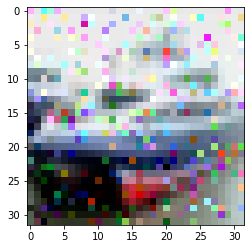

In [26]:
plt.imshow(X_test_noise[1]) 

In [265]:
W_w_dense1 = np.tile(np.expand_dims(W_w3, axis=(0)), [10000,1,1,1]) # (10000, 512, 64, 4)
W_b_dense1 = np.tile(np.expand_dims(W_b3, axis=(0)), [10000,1,1]) # (10000, 64, 4)
W_w_dense2 = np.tile(np.expand_dims(W_w4, axis=(0)), [10000,1,1,1]) # (10000, 64, 10, 4)
W_b_dense2 = np.tile(np.expand_dims(W_b4, axis=(0)), [10000,1,1]) # (10000, 10, 4)

In [266]:
def avg_fusion_dense(W_wx, W_b):
    """
    W_wx - (4, 10, 64, 10000)   
    (4, 64, 512, 10000)
    W_b -  (4, 10, 10000)   
    (4, 64, 10000)
    fusion_result - (4, 10, 10000)
    (4, 64, 10000)
    """
    
    W_wx = W_wx.astype(np.float64)
    W_b = W_b.astype(np.float64)
    
#     n_filter = W_b.shape[1]
    batch_size = W_wx.shape[-1]
    num_para = W_wx.shape[2]
    
#     num_para = W_wx.shape[-2] * W_wx.shape[-3] * W_wx.shape[-4]
#     print(num_para)
    b_wx, u_wx, a_wx = W_wx[0], W_wx[2], W_wx[3]
    b_b, u_b, a_b = W_b[0], W_b[2], W_b[3]
    
    u_combine = np.concatenate((u_wx, np.reshape(u_b,(u_b.shape[0], 1, batch_size))), axis=1) # (64, 513, 10000)
    b_combine = np.concatenate((b_wx, np.reshape(b_b,(b_b.shape[0], 1, batch_size))), axis=1) # (64, 513, 10000)
    u_combine_recip = (np.zeros(u_combine.shape)+1)/u_combine
    
    numerator = np.sum(b_combine * u_combine_recip, axis = 1) # (64, 10000)
    denominator = np.sum(u_combine_recip, axis = (1))
    
    b_fusion = numerator/denominator
    u_fusion = (num_para+1) / denominator
    a_fusion = (np.sum(a_wx, axis=(1)) + a_b) / (num_para+1)
    
    return np.array([b_fusion, 1-b_fusion-u_fusion, u_fusion, a_fusion]), b_fusion + u_fusion * a_fusion

In [267]:
def get_distribution(opinion_last, W_w_dense1, W_b_dense1, W_w_dense2, W_b_dense2):
    """
    opinion_last - (10000, 8, 8, 8, 4)
    W_w_dense1 - (10000, 512, 64, 4)
    W_b_dense1 - (10000, 64, 4)
    W_w_dense1 - (10000, 64, 10, 4)
    W_b_dense1 - (10000, 10, 4)
    
    """
       
    opinion_last = np.reshape(opinion_last, (opinion_last.shape[0],int(opinion_last.shape[1]
                                                *opinion_last.shape[2]*opinion_last.shape[3]),opinion_last.shape[4]))
    
    opinion_last = np.tile(np.expand_dims(opinion_last, axis=(2)), [1,1,64,1])
    W_xw1 = np.array(multi(np.transpose(opinion_last),np.transpose(W_w_dense1))) # (4, 64, 512, 10000)   
    dense1_opinion, _ = avg_fusion_dense(W_xw1, np.transpose(W_b_dense1)) # (4, 64, 10000)

    dense1_opinion = np.tile(np.expand_dims(dense1_opinion, axis=(1)), [1,10,1,1])
    W_xw2 = np.array(multi(dense1_opinion, np.transpose(W_w_dense2))) # (4, 10, 64, 10000)   
    dense2_opinion, dense2_result = avg_fusion_dense(W_xw2, np.transpose(W_b_dense2))

    return dense2_opinion,dense2_result

In [268]:
opinion_original, result_original = get_distribution(opinionlast_test, W_w_dense1, W_b_dense1, W_w_dense2, W_b_dense2)
opinion_fake, result_fake = get_distribution(opinion_last, W_w_dense1, W_b_dense1, W_w_dense2, W_b_dense2)

In [280]:
pred_test = tf.argmax(y_pred_test, axis = 1)
pred_fake = tf.argmax(y_pred_fake, axis = 1)

In [291]:
final_result=[]
for i in range(pred_test.shape[0]):
    final_result.append(np.transpose(result_original)[i][pred_test[i]])
np.array(final_result).shape

(10000,)

In [290]:
final_result_fake=[]
for i in range(pred_fake.shape[0]):
    final_result_fake.append(np.transpose(result_fake)[i][pred_fake[i]])
np.array(final_result_fake)

array([0.20023678, 0.19955617, 0.20927501, ..., 0.20200139, 0.17580387,
       0.17730293])

(array([1520., 2042.,  528.,  843.,  588.,  614., 2208.,  957.,  266.,
         434.]),
 array([0.17331648, 0.17773616, 0.18215585, 0.18657554, 0.19099522,
        0.19541491, 0.19983459, 0.20425428, 0.20867397, 0.21309365,
        0.21751334]),
 <BarContainer object of 10 artists>)

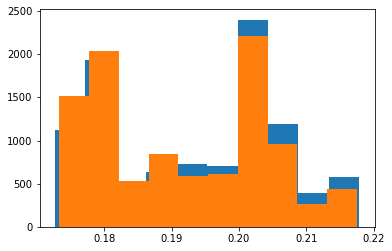

In [293]:
plt.hist(np.array(final_result))
plt.hist(np.array(final_result_fake))

In [274]:
np.transpose(result_fake)
y_pred_fake

array([[0.19571784, 0.19505228, 0.19785672, ..., 0.19453257, 0.19472105,
        0.19637896],
       [0.20703641, 0.20633279, 0.20927501, ..., 0.20578508, 0.20598349,
        0.207731  ],
       [0.17670087, 0.1761081 , 0.17868195, ..., 0.17564149, 0.17580387,
        0.17730293],
       ...,
       [0.20023678, 0.19955617, 0.20241277, ..., 0.19902785, 0.19921824,
        0.20091189],
       [0.21498814, 0.21425573, 0.21729582, ..., 0.2136888 , 0.21389511,
        0.21570588],
       [0.20032587, 0.19964586, 0.2025072 , ..., 0.19911504, 0.19930655,
        0.20100005]])

In [ ]:
# compute Backward opinion of neuron W_N_Y  
W_N_Y=[]
W_y_update = evidence_collect_test(true_label, pre_label)
for j in W_y_update:
    W_N_Y.append(multi(j,y_true_op)) # change when add flaw in label

In [40]:
def image_trust(input_trust, W_N_Y):
    """
    input_trust - (10, 10000) 
    
    """
    
    return trust_result # (10000)

In [183]:
opinion_last

array([[[[[4.2631491e-05, 9.9995703e-01, 3.4547980e-07, 2.0463321e-01],
          [3.3981898e-05, 9.9996567e-01, 3.4547463e-07, 2.0463321e-01],
          [4.6273402e-05, 9.9995339e-01, 3.4548609e-07, 2.0463321e-01],
          ...,
          [2.5587788e-05, 9.9997419e-01, 2.3382921e-07, 1.7857143e-01],
          [2.1023257e-05, 9.9997872e-01, 2.3382466e-07, 1.7857143e-01],
          [4.4173459e-05, 9.9995548e-01, 3.4548620e-07, 2.0463321e-01]],

         [[3.3638109e-05, 9.9996614e-01, 2.3286614e-07, 1.7857143e-01],
          [2.7789276e-05, 9.9997199e-01, 2.3269970e-07, 1.7857143e-01],
          [3.6154190e-05, 9.9996364e-01, 2.3270533e-07, 1.7857143e-01],
          ...,
          [2.5423757e-05, 9.9997437e-01, 2.3269483e-07, 1.7857143e-01],
          [1.8905364e-05, 9.9998093e-01, 1.5640911e-07, 1.3947876e-01],
          [3.4760753e-05, 9.9996501e-01, 2.3286941e-07, 1.7857143e-01]],

         [[2.7590084e-05, 9.9997222e-01, 1.5659391e-07, 1.3947876e-01],
          [2.7814140e-05, 9.99

In [179]:
result_fake

array([[4.66258029e-10, 4.60745990e-10, 4.64966217e-10, ...,
        4.59410771e-10, 4.60940723e-10, 4.69810832e-10],
       [4.68870049e-10, 4.63358325e-10, 4.67659309e-10, ...,
        4.62056317e-10, 4.63562456e-10, 4.72489748e-10],
       [4.91069253e-10, 4.85239239e-10, 4.89658714e-10, ...,
        4.83822313e-10, 4.85443038e-10, 4.94790528e-10],
       ...,
       [4.93816211e-10, 4.87992503e-10, 4.92500719e-10, ...,
        4.86607325e-10, 4.88202471e-10, 4.97605843e-10],
       [4.46707089e-10, 4.41453935e-10, 4.45530058e-10, ...,
        4.40195573e-10, 4.41646940e-10, 4.50144339e-10],
       [4.60256717e-10, 4.54826913e-10, 4.59016812e-10, ...,
        4.53525549e-10, 4.55027113e-10, 4.63786275e-10]])

In [107]:
def get_NN_trust(opinion_last_layer, true_label, pre_label, y_update_wb):
    # compute dense opinion
    opinion_dense = np.average(np.array(opinion_last_layer), axis=0)
    opinion_dense = np.reshape(opinion_dense, 
                                     (int(opinion_dense.shape[0]*opinion_dense.shape[1]*opinion_dense.shape[2]),4))
    y_true_op = [1.0, 0.0, 0.0, 0.5]
    W_y_update = evidence_collect_test(true_label, pre_label)
    
    # compute Backward opinion of neuron W_N_Y  
    W_N_Y=[]
    for j in W_y_update:
        W_N_Y.append(multi(j,y_true_op)) # change when add flaw in label
        
    W_w_dense = y_update_wb[-1]
    W_b_dense = y_update_wb[-1]

    W_xw=[]
    W_xw.append(W_b_dense)
    for j in range(opinion_dense.shape[0]):
        W_xw.append(multi(W_w_dense,opinion_dense[j])) # (513, 4)
    dense_out = fusion(np.array(W_xw))
    #     print('Underflow or not: ',np.isnan(np.min(np.array(dense1_out_list))))

    # last layer
    W_xw=[]
    W_xw.append(W_b_dense)
    for j in range(64):
        W_xw.append(multi(W_w_dense,dense_out))
    W_NN = fusion(np.array(W_xw))
    
    # compute last layer output opinion and trust
    W_XY_one = []
    for j in range(10):
        W_XY_one.append(fusion_2(W_NN,W_N_Y[j]))
    W_NN = fusion(np.array(W_XY_one))
    W_trust = W_NN[0]+W_NN[2]*W_NN[3]
    
    return W_trust, W_NN

In [106]:
print('Fake image trustworthiness result:',get_NN_trust(opinionlast, fake_label, y_pred_fake, y_update_wb)[1])

KeyboardInterrupt: 

In [70]:
print('Orinigal image trustworthiness result:',get_NN_trust(opinionlast_test, y_test, y_pred_test, y_update_wb)[1])

Orinigal image trustworthiness result: 0.5378671459069339


In [45]:
# compute dense opinion
opinion_dense = np.average(np.array(opinionlast_test), axis=0)
opinion_dense = np.reshape(opinion_dense, 
                                 (int(opinion_dense.shape[0]*opinion_dense.shape[1]*opinion_dense.shape[2]),4))
y_true_op = [1.0, 0.0, 0.0, 0.5]

In [47]:
opinion_dense

array([[0.4435952 , 0.5533853 , 0.00302165, 0.1892421 ],
       [0.23215103, 0.7651985 , 0.00265273, 0.19279437],
       [0.26713222, 0.73024976, 0.00261837, 0.1803655 ],
       ...,
       [0.4994517 , 0.4976984 , 0.00285071, 0.15858291],
       [0.34185538, 0.65544856, 0.00269732, 0.16494747],
       [0.5464576 , 0.45077524, 0.00276784, 0.14222182]], dtype=float32)

In [55]:
W_y_update = evidence_collect_test(y_test, y_pred_test)
# compute Backward opinion of neuron W_N_Y  
W_N_Y=[]
for j in W_y_update:
    W_N_Y.append(multi(j,y_true_op)) # change when add flaw in label

In [56]:
W_y_update

array([[0.50980392, 0.47058824, 0.01960784, 0.5       ],
       [0.68627451, 0.29411765, 0.01960784, 0.5       ],
       [0.28431373, 0.69607843, 0.01960784, 0.5       ],
       [0.29411765, 0.68627451, 0.01960784, 0.5       ],
       [0.31372549, 0.66666667, 0.01960784, 0.5       ],
       [0.32352941, 0.65686275, 0.01960784, 0.5       ],
       [0.52941176, 0.45098039, 0.01960784, 0.5       ],
       [0.40196078, 0.57843137, 0.01960784, 0.5       ],
       [0.64705882, 0.33333333, 0.01960784, 0.5       ],
       [0.52941176, 0.45098039, 0.01960784, 0.5       ]])

In [35]:
W_w_dense = y_update_wb[-1]
W_b_dense = y_update_wb[-1]

W_xw=[]
W_xw.append(W_b_dense)
for j in range(opinion_dense.shape[0]):
    W_xw.append(multi(W_w_dense,opinion_dense[j]))
dense_out = fusion(np.array(W_xw))
#     print('Underflow or not: ',np.isnan(np.min(np.array(dense1_out_list))))

# last layer
W_xw=[]
W_xw.append(W_b_dense)
for j in range(64):
    W_xw.append(multi(W_w_dense,dense_out))
W_NN = fusion(np.array(W_xw))

In [36]:
W_NN

[0.22805495573061865,
 0.7582436397540775,
 0.013701404515303833,
 0.04476872928354541]

In [37]:
# compute last layer output opinion and trust
W_XY_one = []
for j in range(10):
    W_XY_one.append(fusion_2(W_NN,W_N_Y[j]))

W_NN = fusion(np.array(W_XY_one))
W_trust = W_NN[0]+W_NN[2]*W_NN[3]

In [38]:
W_trust

0.1852542726890451

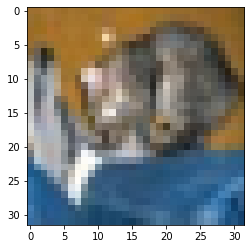

In [25]:
# plt.imshow(X_test[0])
# plt.show()

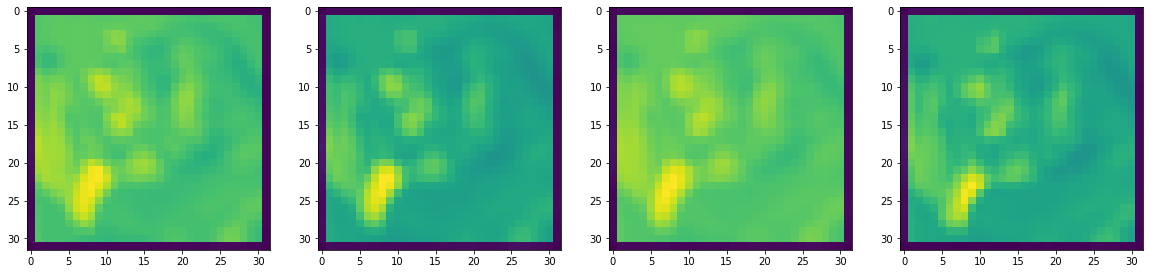

In [46]:
# plt.figure(figsize=(20,20))
# for i in range(1,5):
#     plt.subplot(1,4,i)
#     plt.imshow(trust1[0,:,:,i-1])
# plt.show()

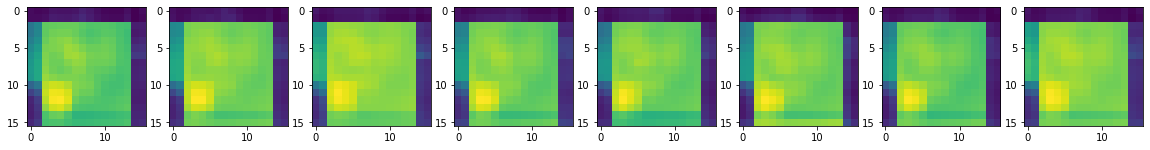

In [47]:
# plt.figure(figsize=(20,20))
# for i in range(1,9):
#     plt.subplot(1,8,i)
#     plt.imshow(trust2[0,:,:,i-1])
# plt.show()

In [450]:
# opinion1 = np.moveaxis(opinion1, -1, 0)
# opinion2 = np.moveaxis(opinion2, -1, 0)

In [452]:
# max_trust1 = opinion1[0]+opinion1[2]*opinion1[3]
# max_trust2 = opinion2[0]+opinion2[2]*opinion2[3]

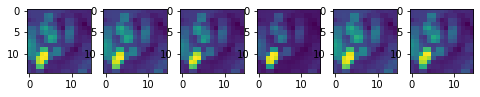

In [455]:
# plt.figure()
# for i in range(1,7):
#     plt.subplot(1,6,i)
#     plt.imshow(max_trust1[0,:,:,i-1])
# plt.show()

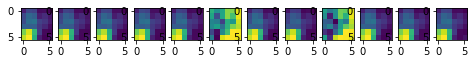

In [456]:
# plt.figure()
# for i in range(1,13):
#     plt.subplot(1,12,i)
#     plt.imshow(max_trust2[0,:,:,i-1])
# plt.show()

In [137]:
# X_test_noise, y_test_noise, noise_opinion = data_loader.get_batch_noise(800,10000)
# y_pred_test_noise,_,_,opinionlast= model([X_test_noise, noise_opinion, W_w1, W_b1, W_w2, W_b2])
# sparse_categorical_accuracy.reset_states()
# sparse_categorical_accuracy.update_state(y_true=y_test_noise, y_pred=y_pred_test_noise)
# print("test accuracy:",sparse_categorical_accuracy.result().numpy())

First 2 layers end: 168828.08871221542
underflow or not: False
Second 2 layers end: 169062.17975068092
test accuracy: 0.4875
